In [1]:
import numpy as np     
import csv 
import copy 
import random
import pandas as pd
import matplotlib.pyplot as plt 
import scipy
from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from pandas import read_csv
import sklearn
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

from geneticalgorithm2 import geneticalgorithm2 as ga # for creating and running optimization model
from geneticalgorithm2 import Crossover, Mutations, Selection # classes for specific mutation and crossover behavior
from geneticalgorithm2 import Population_initializer # for creating better start population
from geneticalgorithm2 import np_lru_cache # for cache function (if u want)
from geneticalgorithm2 import plot_pop_scores # for plotting population scores, if u want
from geneticalgorithm2 import Callbacks # simple callbacks
from geneticalgorithm2 import Actions, ActionConditions, MiddleCallbacks # middle callbacks

import warnings
warnings.filterwarnings("ignore")


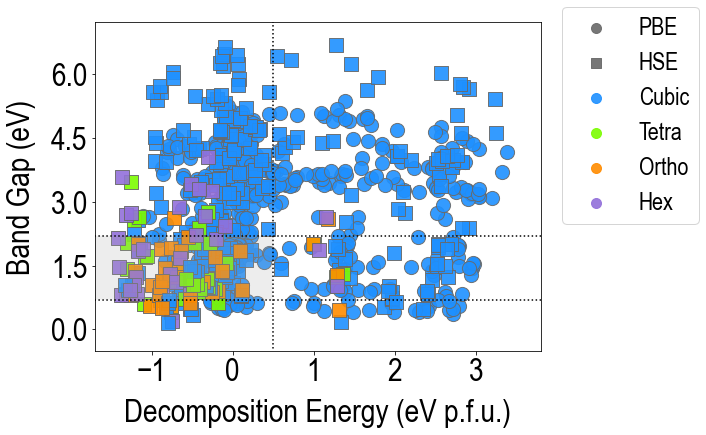

In [6]:
###   Visualize DFT Data, Decomp vs Gap    ###

#Data = pd.read_excel('DFT_pred.xlsx', 'PBE_sf')
#Data = pd.read_excel('DFT_pred.xlsx', 'HSE_sf')
#Data = pd.read_excel('DFT_pred.xlsx', 'PBE_HSE_mf1')
Data = pd.read_excel('DFT_pred.xlsx', 'PBE_HSE_expt_mf2')

n = len(Data.Index[:])

fig = plt.figure( figsize=(10,6) )
plt.subplots_adjust(left=0.14, bottom=0.20, right=0.76, top=0.96)
plt.rc('font', family='Arial narrow')

for i in range(0,n):

    if Data.Expt[i] == 1:
        plt.scatter(Data.Decomp[i], Data.Gap[i], c='dodgerblue', marker='*', s=300, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if Data.Cubic[i] == 1:
        if Data.PBE[i] == 1:
            plt.scatter(Data.Decomp[i], Data.Gap[i], c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if Data.HSE[i] == 1:
            plt.scatter(Data.Decomp[i], Data.Gap[i], c='dodgerblue', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if Data.Tetra[i] == 1:
        if Data.PBE[i] == 1:
            plt.scatter(Data.Decomp[i], Data.Gap[i], c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if Data.HSE[i] == 1:
            plt.scatter(Data.Decomp[i], Data.Gap[i], c='lawngreen', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if Data.Ortho[i] == 1:
        if Data.PBE[i] == 1:
            plt.scatter(Data.Decomp[i], Data.Gap[i], c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if Data.HSE[i] == 1:
            plt.scatter(Data.Decomp[i], Data.Gap[i], c='darkorange', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if Data.Hex[i] == 1:
        if Data.PBE[i] == 1:
            plt.scatter(Data.Decomp[i], Data.Gap[i], c='mediumpurple', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if Data.HSE[i] == 1:
            plt.scatter(Data.Decomp[i], Data.Gap[i], c='mediumpurple', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

plt.scatter(1000, 1000, c='dimgrey', marker='o', s=100, edgecolors='dimgrey', alpha=0.9, label='PBE')
plt.scatter(1000, 1000, c='dimgrey', marker='s', s=100, edgecolors='dimgrey', alpha=0.9, label='HSE')
#plt.scatter(1000, 1000, c='dimgrey', marker='*', s=200, edgecolors='dimgrey', alpha=0.9, label='Expt.')
plt.scatter(1000, 1000, c='dodgerblue', marker='o', s=100, edgecolors='dodgerblue', alpha=0.9, label='Cubic')
plt.scatter(1000, 1000, c='lawngreen', marker='o', s=100, edgecolors='lawngreen', alpha=0.9, label='Tetra')
plt.scatter(1000, 1000, c='darkorange', marker='o', s=100, edgecolors='darkorange', alpha=0.9, label='Ortho')
plt.scatter(1000, 1000, c='mediumpurple', marker='o', s=100, edgecolors='mediumpurple', alpha=0.9, label='Hex')

a = [0.7,0.7,0.7]
b = [-1000,0,1000]
c = [0.5,0.5,0.5]
d = [2.2,2.2,2.2]
plt.plot(b, a, c='k', ls=':')
plt.plot(b, d, c='k', ls=':')
plt.plot(c, b, c='k', ls=':')
x1 = np.arange(-1000, c[0],  0.01)

plt.fill_between(x1, a[0], d[0], facecolor='darkgrey', alpha=0.2)

plt.xlim([-1.7, 3.8])
plt.ylim([-0.5, 7.2])
plt.xticks([-1.0, 0.0, 1.0, 2.0, 3.0], fontsize=32)
plt.yticks([0.0, 1.5, 3.0, 4.5, 6.0], fontsize=32)
plt.xlabel('Decomposition Energy (eV p.f.u.)', fontsize=32, labelpad=12)
plt.ylabel('Band Gap (eV)', fontsize=32, labelpad=15)
#plt.title('Decomposition Energy (eV)', c='k', fontsize=20, pad=12)
plt.legend(bbox_to_anchor=(1.02,0.35), ncol=1, frameon=True, prop={'family':'Arial narrow','size':24})

plt.savefig('plot_decomp_gap.pdf', dpi=450)




#plt.scatter(Data.Gap[:], Data.SLME[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')






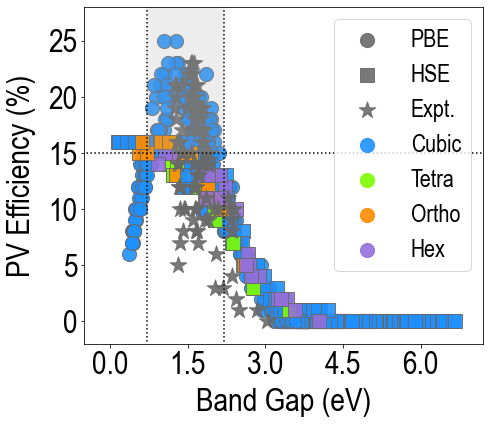

In [13]:
###   Visualize DFT Data, Gap vs SLME    ###

#Data = pd.read_excel('DFT_pred.xlsx', 'PBE_sf')
#Data = pd.read_excel('DFT_pred.xlsx', 'HSE_sf')
#Data = pd.read_excel('DFT_pred.xlsx', 'PBE_HSE_mf1')
Data = pd.read_excel('DFT_pred.xlsx', 'PBE_HSE_expt_mf2')

n = len(Data.Index[:])

fig = plt.figure( figsize=(7,6) )
plt.subplots_adjust(left=0.18, bottom=0.18, right=0.97, top=0.96)
plt.rc('font', family='Arial narrow')

for i in range(0,n):

    if Data.Expt[i] == 1:
        plt.scatter(Data.Gap[i], Data.SLME[i]*100, c='dimgrey', marker='*', s=300, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if Data.Cubic[i] == 1:
        if Data.PBE[i] == 1:
            plt.scatter(Data.Gap[i], Data.SLME[i]*100, c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if Data.HSE[i] == 1:
            plt.scatter(Data.Gap[i], Data.SLME[i]*100, c='dodgerblue', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if Data.Tetra[i] == 1:
        if Data.PBE[i] == 1:
            plt.scatter(Data.Gap[i], Data.SLME[i]*100, c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if Data.HSE[i] == 1:
            plt.scatter(Data.Gap[i], Data.SLME[i]*100, c='lawngreen', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if Data.Ortho[i] == 1:
        if Data.PBE[i] == 1:
            plt.scatter(Data.Gap[i], Data.SLME[i]*100, c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if Data.HSE[i] == 1:
            plt.scatter(Data.Gap[i], Data.SLME[i]*100, c='darkorange', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if Data.Hex[i] == 1:
        if Data.PBE[i] == 1:
            plt.scatter(Data.Gap[i], Data.SLME[i]*100, c='mediumpurple', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if Data.HSE[i] == 1:
            plt.scatter(Data.Gap[i], Data.SLME[i]*100, c='mediumpurple', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

plt.scatter(1000, 1000, c='dimgrey', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='PBE')
plt.scatter(1000, 1000, c='dimgrey', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='HSE')
plt.scatter(1000, 1000, c='dimgrey', marker='*', s=300, edgecolors='dimgrey', alpha=0.9, label='Expt.')
plt.scatter(1000, 1000, c='dodgerblue', marker='o', s=200, edgecolors='dodgerblue', alpha=0.9, label='Cubic')
plt.scatter(1000, 1000, c='lawngreen', marker='o', s=200, edgecolors='lawngreen', alpha=0.9, label='Tetra')
plt.scatter(1000, 1000, c='darkorange', marker='o', s=200, edgecolors='darkorange', alpha=0.9, label='Ortho')
plt.scatter(1000, 1000, c='mediumpurple', marker='o', s=200, edgecolors='mediumpurple', alpha=0.9, label='Hex')

a = [0.7,0.7,0.7]
b = [-1000,0,1000]
c = [15,15,15]
d = [2.2,2.2,2.2]
plt.plot(a, b, c='k', ls=':')
plt.plot(d, b, c='k', ls=':')
plt.plot(b, c, c='k', ls=':')
x1 = np.arange(a[0], d[0],  0.01)

plt.fill_between(x1, c[0], 1000, facecolor='darkgrey', alpha=0.2)

plt.ylim([-2, 28])
plt.xlim([-0.5, 7.2])
plt.yticks([0, 5, 10, 15, 20, 25], fontsize=32)
plt.xticks([0.0, 1.5, 3.0, 4.5, 6.0], fontsize=32)
plt.ylabel('PV Efficiency (%)', fontsize=32, labelpad=12)
plt.xlabel('Band Gap (eV)', fontsize=32, labelpad=8)
plt.legend(loc='upper right', ncol=1, frameon=True, prop={'family':'Arial narrow','size':24})

plt.savefig('plot_gap_slme.pdf', dpi=450)





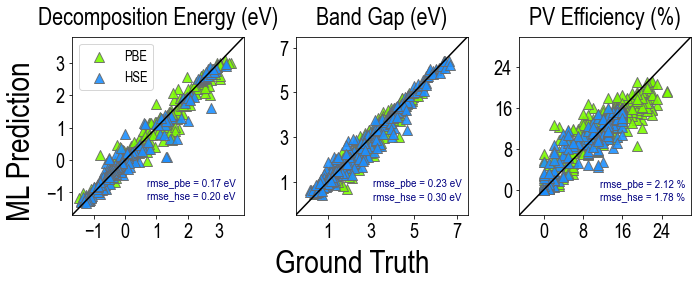

In [25]:
###   DFT vs ML Parity Plots, PBE Single Fidelity   ###

Data_1 = pd.read_excel('DFT_pred.xlsx', 'PBE_sf')
Data_2 = pd.read_excel('DFT_pred.xlsx', 'HSE_sf')


Decomp_dft_pbe = Data_1.Decomp[:]
Decomp_ml_pbe = Data_1.ML_decomp_mean[:]
Gap_dft_pbe = Data_1.Gap[:]
Gap_ml_pbe = Data_1.ML_gap_mean[:]
SLME_dft_pbe = Data_1.SLME[:]*100
SLME_ml_pbe = Data_1.ML_slme_mean[:]*100

decomp_rmse_pbe = np.sqrt( sklearn.metrics.mean_squared_error(Decomp_dft_pbe[:],Decomp_ml_pbe[:]) )
gap_rmse_pbe = np.sqrt( sklearn.metrics.mean_squared_error(Gap_dft_pbe[:],Gap_ml_pbe[:]) )
slme_rmse_pbe = np.sqrt( sklearn.metrics.mean_squared_error(SLME_dft_pbe[:],SLME_ml_pbe[:]) )


Decomp_dft_hse = Data_2.Decomp[:]
Decomp_ml_hse = Data_2.ML_decomp_mean[:]
Gap_dft_hse = Data_2.Gap[:]
Gap_ml_hse = Data_2.ML_gap_mean[:]
SLME_dft_hse = Data_2.SLME[:]*100
SLME_ml_hse = Data_2.ML_slme_mean[:]*100

decomp_rmse_hse = np.sqrt( sklearn.metrics.mean_squared_error(Decomp_dft_hse[:],Decomp_ml_hse[:]) )
gap_rmse_hse = np.sqrt( sklearn.metrics.mean_squared_error(Gap_dft_hse[:],Gap_ml_hse[:]) )
slme_rmse_hse = np.sqrt( sklearn.metrics.mean_squared_error(SLME_dft_hse[:],SLME_ml_hse[:]) )


n = len(Data.Index[:])
    
fig, ( [ax1, ax2, ax3] ) = plt.subplots( nrows=1, ncols=3, figsize=(10,4) )
fig.text(0.5, 0.04, 'Ground Truth', ha='center', fontsize=32)
fig.text(0.02, 0.5, 'ML Prediction', va='center', rotation='vertical', fontsize=32)
plt.subplots_adjust(left=0.11, bottom=0.24, right=0.97, top=0.86, wspace=0.30, hspace=0.40)
plt.rc('font', family='Arial narrow')
a = [-175,0,125]
b = [-175,0,125]

ax1.plot(b, a, c='k', ls='-')
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
te = '%.2f' % decomp_rmse_pbe
ax1.text(0.7, -0.8, 'rmse_pbe = ' + te + ' eV', c='navy', fontsize=12)
te = '%.2f' % decomp_rmse_hse
ax1.text(0.7, -1.2, 'rmse_hse = ' + te + ' eV', c='navy', fontsize=12)
ax1.set_xlim([-1.7, 3.8])
ax1.set_ylim([-1.7, 3.8])
ax1.set_xticks([-1.0, 0.0, 1.0, 2.0, 3.0])
ax1.set_yticks([-1.0, 0.0, 1.0, 2.0, 3.0])
ax1.set_title('Decomposition Energy (eV)', c='k', fontsize=24, pad=12)
ax1.scatter(Decomp_dft_pbe[:], Decomp_ml_pbe[:], c='lawngreen', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
ax1.scatter(Decomp_dft_hse[:], Decomp_ml_hse[:], c='dodgerblue', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
ax1.scatter(1000, 1000, c='lawngreen', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='PBE')
ax1.scatter(1000, 1000, c='dodgerblue', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='HSE')
ax1.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':14})

ax2.plot(b, a, c='k', ls='-')
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
te = '%.2f' % gap_rmse_pbe
ax2.text(3.1, 0.8, 'rmse_pbe = ' + te + ' eV', c='navy', fontsize=12)
te = '%.2f' % gap_rmse_hse
ax2.text(3.1, 0.2, 'rmse_hse = ' + te + ' eV', c='navy', fontsize=12)
ax2.set_xlim([-0.5, 7.5])
ax2.set_ylim([-0.5, 7.5])
ax2.set_xticks([1.0, 3.0, 5.0, 7.0])
ax2.set_yticks([1.0, 3.0, 5.0, 7.0])
ax2.set_title('Band Gap (eV)', c='k', fontsize=24, pad=12)
ax2.scatter(Gap_dft_pbe[:], Gap_ml_pbe[:], c='lawngreen', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
ax2.scatter(Gap_dft_hse[:], Gap_ml_hse[:], c='dodgerblue', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

ax3.plot(b, a, c='k', ls='-')
ax3.xaxis.set_tick_params(labelsize=20)
ax3.yaxis.set_tick_params(labelsize=20)
te = '%.2f' % slme_rmse_pbe
ax3.text(11.5, 0.4, 'rmse_pbe = ' + te + ' %', c='navy', fontsize=12)
te = '%.2f' % slme_rmse_hse
ax3.text(11.5, -2.0, 'rmse_hse = ' + te + ' %', c='navy', fontsize=12)
ax3.set_ylim([-5, 30])
ax3.set_xlim([-5, 30])
ax3.set_xticks([0, 8, 16, 24])
ax3.set_yticks([0, 8, 16, 24])
#ax3.set_title('SLME at 5$\mu$m (%)', fontsize=24, pad=12)
ax3.set_title('PV Efficiency (%)', fontsize=24, pad=12)
ax3.scatter(SLME_dft_pbe[:], SLME_ml_pbe[:], c='lawngreen', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
ax3.scatter(SLME_dft_hse[:], SLME_ml_hse[:], c='dodgerblue', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')


plt.savefig('plot_ml_sf.pdf', dpi=450)

        

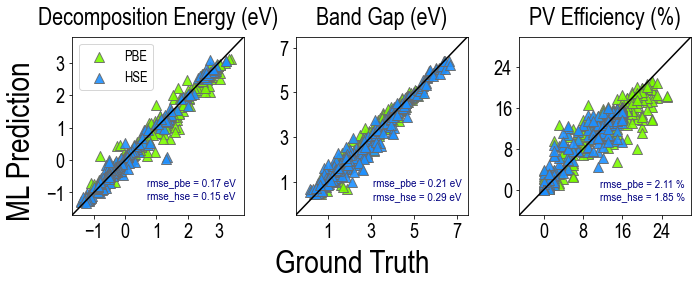

In [29]:
###   DFT vs ML Parity Plots, multi-fidelity 1   ###

Data = pd.read_excel('DFT_pred.xlsx', 'PBE_HSE_mf1')
n = len(Data.Index[:])

n_1 = 0
n_2 = 0

for i in range(0,n):
    if Data.PBE[i] == 1:
        n_1 = n_1 + 1
    if Data.HSE[i] == 1:
        n_2 = n_2 + 1
    
Decomp_dft_pbe = [0.0]*n_1
Decomp_ml_pbe = [0.0]*n_1
Gap_dft_pbe = [0.0]*n_1
Gap_ml_pbe = [0.0]*n_1
SLME_dft_pbe = [0.0]*n_1
SLME_ml_pbe = [0.0]*n_1

Decomp_dft_hse = [0.0]*n_2
Decomp_ml_hse = [0.0]*n_2
Gap_dft_hse = [0.0]*n_2
Gap_ml_hse = [0.0]*n_2
SLME_dft_hse = [0.0]*n_2
SLME_ml_hse = [0.0]*n_2

k = 0
for i in range(0,n):
    if Data.PBE[i] == 1:
        Decomp_dft_pbe[k] = Data.Decomp[i]
        Decomp_ml_pbe[k] = Data.ML_decomp_mean[i]
        Gap_dft_pbe[k] = Data.Gap[i]
        Gap_ml_pbe[k] = Data.ML_gap_mean[i]
        SLME_dft_pbe[k] = Data.SLME[i]*100
        SLME_ml_pbe[k] = Data.ML_slme_mean[i]*100
        k = k+1

k = 0
for i in range(0,n):
    if Data.HSE[i] == 1:
        Decomp_dft_hse[k] = Data.Decomp[i]
        Decomp_ml_hse[k] = Data.ML_decomp_mean[i]
        Gap_dft_hse[k] = Data.Gap[i]
        Gap_ml_hse[k] = Data.ML_gap_mean[i]
        SLME_dft_hse[k] = Data.SLME[i]*100
        SLME_ml_hse[k] = Data.ML_slme_mean[i]*100
        k = k+1


decomp_rmse_pbe = np.sqrt( sklearn.metrics.mean_squared_error(Decomp_dft_pbe[:],Decomp_ml_pbe[:]) )
gap_rmse_pbe = np.sqrt( sklearn.metrics.mean_squared_error(Gap_dft_pbe[:],Gap_ml_pbe[:]) )
slme_rmse_pbe = np.sqrt( sklearn.metrics.mean_squared_error(SLME_dft_pbe[:],SLME_ml_pbe[:]) )

decomp_rmse_hse = np.sqrt( sklearn.metrics.mean_squared_error(Decomp_dft_hse[:],Decomp_ml_hse[:]) )
gap_rmse_hse = np.sqrt( sklearn.metrics.mean_squared_error(Gap_dft_hse[:],Gap_ml_hse[:]) )
slme_rmse_hse = np.sqrt( sklearn.metrics.mean_squared_error(SLME_dft_hse[:],SLME_ml_hse[:]) )

    
fig, ( [ax1, ax2, ax3] ) = plt.subplots( nrows=1, ncols=3, figsize=(10,4) )
fig.text(0.5, 0.04, 'Ground Truth', ha='center', fontsize=32)
fig.text(0.02, 0.5, 'ML Prediction', va='center', rotation='vertical', fontsize=32)
plt.subplots_adjust(left=0.11, bottom=0.24, right=0.97, top=0.86, wspace=0.30, hspace=0.40)
plt.rc('font', family='Arial narrow')
a = [-175,0,125]
b = [-175,0,125]

ax1.plot(b, a, c='k', ls='-')
ax1.xaxis.set_tick_params(labelsize=20)
ax1.yaxis.set_tick_params(labelsize=20)
te = '%.2f' % decomp_rmse_pbe
ax1.text(0.7, -0.8, 'rmse_pbe = ' + te + ' eV', c='navy', fontsize=12)
te = '%.2f' % decomp_rmse_hse
ax1.text(0.7, -1.2, 'rmse_hse = ' + te + ' eV', c='navy', fontsize=12)
ax1.set_xlim([-1.7, 3.8])
ax1.set_ylim([-1.7, 3.8])
ax1.set_xticks([-1.0, 0.0, 1.0, 2.0, 3.0])
ax1.set_yticks([-1.0, 0.0, 1.0, 2.0, 3.0])
ax1.set_title('Decomposition Energy (eV)', c='k', fontsize=24, pad=12)
ax1.scatter(Decomp_dft_pbe[:], Decomp_ml_pbe[:], c='lawngreen', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
ax1.scatter(Decomp_dft_hse[:], Decomp_ml_hse[:], c='dodgerblue', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
ax1.scatter(1000, 1000, c='lawngreen', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='PBE')
ax1.scatter(1000, 1000, c='dodgerblue', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='HSE')
ax1.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':14})

ax2.plot(b, a, c='k', ls='-')
ax2.xaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)
te = '%.2f' % gap_rmse_pbe
ax2.text(3.1, 0.8, 'rmse_pbe = ' + te + ' eV', c='navy', fontsize=12)
te = '%.2f' % gap_rmse_hse
ax2.text(3.1, 0.2, 'rmse_hse = ' + te + ' eV', c='navy', fontsize=12)
ax2.set_xlim([-0.5, 7.5])
ax2.set_ylim([-0.5, 7.5])
ax2.set_xticks([1.0, 3.0, 5.0, 7.0])
ax2.set_yticks([1.0, 3.0, 5.0, 7.0])
ax2.set_title('Band Gap (eV)', c='k', fontsize=24, pad=12)
ax2.scatter(Gap_dft_pbe[:], Gap_ml_pbe[:], c='lawngreen', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
ax2.scatter(Gap_dft_hse[:], Gap_ml_hse[:], c='dodgerblue', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

ax3.plot(b, a, c='k', ls='-')
ax3.xaxis.set_tick_params(labelsize=20)
ax3.yaxis.set_tick_params(labelsize=20)
te = '%.2f' % slme_rmse_pbe
ax3.text(11.5, 0.4, 'rmse_pbe = ' + te + ' %', c='navy', fontsize=12)
te = '%.2f' % slme_rmse_hse
ax3.text(11.5, -2.0, 'rmse_hse = ' + te + ' %', c='navy', fontsize=12)
ax3.set_ylim([-5, 30])
ax3.set_xlim([-5, 30])
ax3.set_xticks([0, 8, 16, 24])
ax3.set_yticks([0, 8, 16, 24])
#ax3.set_title('SLME at 5$\mu$m (%)', fontsize=24, pad=12)
ax3.set_title('PV Efficiency (%)', fontsize=24, pad=12)
ax3.scatter(SLME_dft_pbe[:], SLME_ml_pbe[:], c='lawngreen', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
ax3.scatter(SLME_dft_hse[:], SLME_ml_hse[:], c='dodgerblue', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')


plt.savefig('plot_ml_mf1.pdf', dpi=450)

        

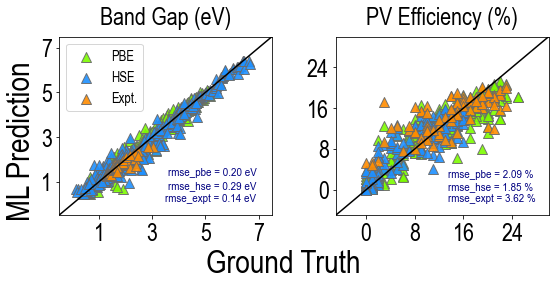

In [11]:
###   DFT vs ML Parity Plots, multi-fidelity 2   ###

Data = pd.read_excel('DFT_pred.xlsx', 'PBE_HSE_expt_mf2')

Gap_dft = Data.Gap[:]
Gap_ml = Data.ML_gap_mean[:]
SLME_dft = Data.SLME[:]*100
SLME_ml = Data.ML_slme_mean[:]*100

n = len(Data.Index[:])

n_1 = 0
n_2 = 0
n_3 = 0

for i in range(0,n):
    if Data.PBE[i] == 1:
        n_1 = n_1 + 1
    if Data.HSE[i] == 1:
        n_2 = n_2 + 1
    if Data.Expt[i] == 1:
        n_3 = n_3 + 1

Gap_dft_pbe = [0.0]*n_1
Gap_ml_pbe = [0.0]*n_1
SLME_dft_pbe = [0.0]*n_1
SLME_ml_pbe = [0.0]*n_1

Gap_dft_hse = [0.0]*n_2
Gap_ml_hse = [0.0]*n_2
SLME_dft_hse = [0.0]*n_2
SLME_ml_hse = [0.0]*n_2

Gap_expt_actual = [0.0]*n_3
Gap_expt_ml = [0.0]*n_3
SLME_expt_actual = [0.0]*n_3
SLME_expt_ml = [0.0]*n_3

k = 0
for i in range(0,n):
    if Data.PBE[i] == 1:
        Gap_dft_pbe[k] = Data.Gap[i]
        Gap_ml_pbe[k] = Data.ML_gap_mean[i]
        SLME_dft_pbe[k] = Data.SLME[i]*100
        SLME_ml_pbe[k] = Data.ML_slme_mean[i]*100
        k = k+1

k = 0
for i in range(0,n):
    if Data.HSE[i] == 1:
        Gap_dft_hse[k] = Data.Gap[i]
        Gap_ml_hse[k] = Data.ML_gap_mean[i]
        SLME_dft_hse[k] = Data.SLME[i]*100
        SLME_ml_hse[k] = Data.ML_slme_mean[i]*100
        k = k+1

k = 0
for i in range(0,n):
    if Data.Expt[i] == 1:
        Gap_expt_actual[k] = Data.Gap[i]
        Gap_expt_ml[k] = Data.ML_gap_mean[i]
        SLME_expt_actual[k] = Data.SLME[i]*100
        SLME_expt_ml[k] = Data.ML_slme_mean[i]*100
        k = k+1

gap_rmse_pbe = np.sqrt( sklearn.metrics.mean_squared_error(Gap_dft_pbe[:],Gap_ml_pbe[:]) )
slme_rmse_pbe = np.sqrt( sklearn.metrics.mean_squared_error(SLME_dft_pbe[:],SLME_ml_pbe[:]) )

gap_rmse_hse = np.sqrt( sklearn.metrics.mean_squared_error(Gap_dft_hse[:],Gap_ml_hse[:]) )
slme_rmse_hse = np.sqrt( sklearn.metrics.mean_squared_error(SLME_dft_hse[:],SLME_ml_hse[:]) )

gap_rmse_expt = np.sqrt( sklearn.metrics.mean_squared_error(Gap_expt_actual[:],Gap_expt_ml[:]) )
slme_rmse_expt = np.sqrt( sklearn.metrics.mean_squared_error(SLME_expt_actual[:],SLME_expt_ml[:]) )




n = len(Data.Index[:])
    
fig, ( [ax1, ax2] ) = plt.subplots( nrows=1, ncols=2, figsize=(8,4) )
fig.text(0.5, 0.04, 'Ground Truth', ha='center', fontsize=32)
fig.text(0.02, 0.5, 'ML Prediction', va='center', rotation='vertical', fontsize=32)
plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
plt.rc('font', family='Arial narrow')
a = [-175,0,125]
b = [-175,0,125]

ax1.plot(b, a, c='k', ls='-')
ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=24)
te = '%.2f' % gap_rmse_pbe
ax1.text(3.6, 1.3, 'rmse_pbe = ' + te + ' eV', c='navy', fontsize=12)
te = '%.2f' % gap_rmse_hse
ax1.text(3.6, 0.7, 'rmse_hse = ' + te + ' eV', c='navy', fontsize=12)
te = '%.2f' % gap_rmse_expt
ax1.text(3.5, 0.1, 'rmse_expt = ' + te + ' eV', c='navy', fontsize=12)
ax1.set_xlim([-0.5, 7.5])
ax1.set_ylim([-0.5, 7.5])
ax1.set_xticks([1.0, 3.0, 5.0, 7.0])
ax1.set_yticks([1.0, 3.0, 5.0, 7.0])
ax1.set_title('Band Gap (eV)', c='k', fontsize=24, pad=12)
for i in range(0,n):
    if Data.PBE[i] == 1:
        ax1.scatter(Gap_dft[i], Gap_ml[i], c='lawngreen', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
    if Data.HSE[i] == 1:
        ax1.scatter(Gap_dft[i], Gap_ml[i], c='dodgerblue', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
    if Data.Expt[i] == 1:
        ax1.scatter(Gap_dft[i], Gap_ml[i], c='darkorange', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
ax1.scatter(1000, 1000, c='lawngreen', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='PBE')
ax1.scatter(1000, 1000, c='dodgerblue', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='HSE')
ax1.scatter(1000, 1000, c='darkorange', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='Expt.')
ax1.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':14})

ax2.plot(b, a, c='k', ls='-')
ax2.xaxis.set_tick_params(labelsize=24)
ax2.yaxis.set_tick_params(labelsize=24)
te = '%.2f' % slme_rmse_pbe
ax2.text(13.5, 2.4, 'rmse_pbe = ' + te + ' %', c='navy', fontsize=12)
te = '%.2f' % slme_rmse_hse
ax2.text(13.5, 0.0, 'rmse_hse = ' + te + ' %', c='navy', fontsize=12)
te = '%.2f' % slme_rmse_expt
ax2.text(13.4, -2.4, 'rmse_expt = ' + te + ' %', c='navy', fontsize=12)
ax2.set_ylim([-5, 30])
ax2.set_xlim([-5, 30])
ax2.set_xticks([0, 8, 16, 24])
ax2.set_yticks([0, 8, 16, 24])
ax2.set_title('PV Efficiency (%)', fontsize=24, pad=12)
for i in range(0,n):
    if Data.PBE[i] == 1:
        ax2.scatter(SLME_dft[i], SLME_ml[i], c='lawngreen', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
    if Data.HSE[i] == 1:
        ax2.scatter(SLME_dft[i], SLME_ml[i], c='dodgerblue', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
    if Data.Expt[i] == 1:
        ax2.scatter(SLME_dft[i], SLME_ml[i], c='darkorange', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')


plt.savefig('plot_ml_mf2.pdf', dpi=450)



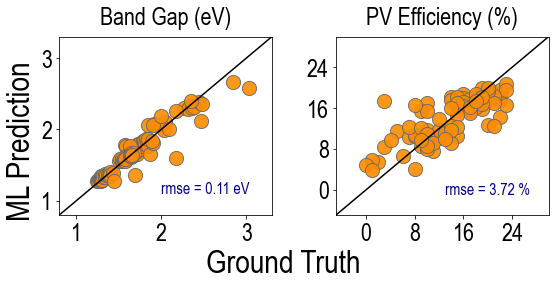

In [3]:
###   Expt. SF Model   ###

Data = pd.read_excel('DFT_pred.xlsx', 'Expt_sf')

Gap_expt = Data.Gap[:]
Gap_ml = Data.ML_gap_mean[:]
SLME_expt = Data.SLME[0:87]*100
SLME_ml = Data.ML_slme_mean[0:87]*100

n = len(Data.Index[:])

gap_rmse = np.sqrt( sklearn.metrics.mean_squared_error(Gap_expt[:],Gap_ml[:]) )
slme_rmse = np.sqrt( sklearn.metrics.mean_squared_error(SLME_expt[:],SLME_ml[:]) )
    
fig, ( [ax1, ax2] ) = plt.subplots( nrows=1, ncols=2, figsize=(8,4) )
fig.text(0.5, 0.04, 'Ground Truth', ha='center', fontsize=32)
fig.text(0.02, 0.5, 'ML Prediction', va='center', rotation='vertical', fontsize=32)
plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
plt.rc('font', family='Arial narrow')
a = [-175,0,125]
b = [-175,0,125]

ax1.plot(b, a, c='k', ls='-')
ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=24)
te = '%.2f' % gap_rmse
ax1.text(2.0, 1.1, 'rmse = ' + te + ' eV', c='navy', fontsize=16)
ax1.set_xlim([0.8, 3.3])
ax1.set_ylim([0.8, 3.3])
ax1.set_xticks([1.0, 2.0, 3.0])
ax1.set_yticks([1.0, 2.0, 3.0])
ax1.set_title('Band Gap (eV)', c='k', fontsize=24, pad=12)
ax1.scatter(Gap_expt[:], Gap_ml[:], c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
#ax1.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':14})

ax2.plot(b, a, c='k', ls='-')
ax2.xaxis.set_tick_params(labelsize=24)
ax2.yaxis.set_tick_params(labelsize=24)
te = '%.2f' % slme_rmse
ax2.text(13, -1.0, 'rmse = ' + te + ' %', c='navy', fontsize=16)
ax2.set_ylim([-5, 30])
ax2.set_xlim([-5, 30])
ax2.set_xticks([0, 8, 16, 24])
ax2.set_yticks([0, 8, 16, 24])
ax2.set_title('PV Efficiency (%)', fontsize=24, pad=12)
ax2.scatter(SLME_expt[:], SLME_ml[:], c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')


plt.savefig('plot_expt_sf.pdf', dpi=450)



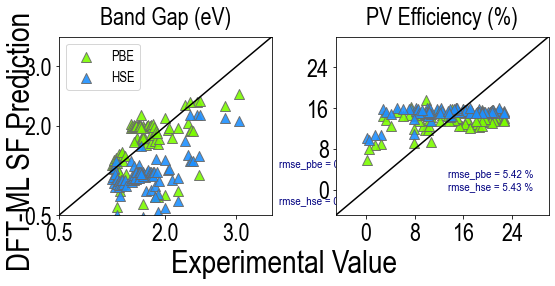

In [17]:
###   Expt vs PBE-ML and HSE-ML   ###

Data_pbe = pd.read_excel('Expt_pred.xlsx', 'PBE_sf')
Data_hse = pd.read_excel('Expt_pred.xlsx', 'HSE_sf')
#Data_pbe = pd.read_excel('Expt_pred.xlsx', 'PBE_mf1')
#Data_hse = pd.read_excel('Expt_pred.xlsx', 'HSE_mf1')
#Data_pbe = pd.read_excel('Expt_pred.xlsx', 'PBE_mf2')
#Data_hse = pd.read_excel('Expt_pred.xlsx', 'HSE_mf2')
#Data = pd.read_excel('Expt_pred.xlsx', 'Expt_mf2')

gap_rmse_pbe = np.sqrt( sklearn.metrics.mean_squared_error(Data_pbe.Expt_gap[:], Data_pbe.Pred_gap_mean[:]) )
slme_rmse_pbe = np.sqrt( sklearn.metrics.mean_squared_error(Data_pbe.Expt_pce[0:86]*100, Data_pbe.Pred_slme_mean[0:86]*100) )

gap_rmse_hse = np.sqrt( sklearn.metrics.mean_squared_error(Data_hse.Expt_gap[:], Data_hse.Pred_gap_mean[:]) )
slme_rmse_hse = np.sqrt( sklearn.metrics.mean_squared_error(Data_hse.Expt_pce[0:86]*100, Data_hse.Pred_slme_mean[0:86]*100) )

#gap_rmse = np.sqrt( sklearn.metrics.mean_squared_error(Expt_gap[:], Pred_gap_low_en[:]) )
#slme_rmse = np.sqrt( sklearn.metrics.mean_squared_error(Expt_pce[:], Pred_slme_low_en[:]) )


n = len(Data.Index[:])
    
fig, ( [ax1, ax2] ) = plt.subplots( nrows=1, ncols=2, figsize=(8,4) )
fig.text(0.5, 0.04, 'Experimental Value', ha='center', fontsize=32)
fig.text(0.02, 0.5, 'DFT-ML SF Prediction', va='center', rotation='vertical', fontsize=32)
#fig.text(0.02, 0.5, 'DFT-ML MF1 Prediction', va='center', rotation='vertical', fontsize=32)
#fig.text(0.02, 0.5, 'DFT-ML MF2 Prediction', va='center', rotation='vertical', fontsize=32)
plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
plt.rc('font', family='Arial narrow')
a = [-175,0,125]
b = [-175,0,125]

ax1.plot(b, a, c='k', ls='-')
ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=24)
te = '%.2f' % gap_rmse_pbe
ax1.text(3.6, 1.3, 'rmse_pbe = ' + te + ' eV', c='navy', fontsize=12)
te = '%.2f' % gap_rmse_hse
ax1.text(3.6, 0.7, 'rmse_hse = ' + te + ' eV', c='navy', fontsize=12)
ax1.set_xlim([1.0, 3.5])
ax1.set_ylim([1.0, 3.5])
ax1.set_xticks([0.5, 2.0, 3.0])
ax1.set_yticks([0.5, 2.0, 3.0])
ax1.set_title('Band Gap (eV)', c='k', fontsize=24, pad=12)
ax1.scatter(Data_pbe.Expt_gap[:], Data_pbe.Pred_gap_mean[:], c='lawngreen', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
ax1.scatter(Data_hse.Expt_gap[:], Data_hse.Pred_gap_mean[:], c='dodgerblue', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
ax1.scatter(1000, 1000, c='lawngreen', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='PBE')
ax1.scatter(1000, 1000, c='dodgerblue', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='HSE')
ax1.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':14})

ax2.plot(b, a, c='k', ls='-')
ax2.xaxis.set_tick_params(labelsize=24)
ax2.yaxis.set_tick_params(labelsize=24)
te = '%.2f' % slme_rmse_pbe
ax2.text(13.5, 2.4, 'rmse_pbe = ' + te + ' %', c='navy', fontsize=12)
te = '%.2f' % slme_rmse_hse
ax2.text(13.5, 0.0, 'rmse_hse = ' + te + ' %', c='navy', fontsize=12)
ax2.set_ylim([-5, 30])
ax2.set_xlim([-5, 30])
ax2.set_xticks([0, 8, 16, 24])
ax2.set_yticks([0, 8, 16, 24])
ax2.set_title('PV Efficiency (%)', fontsize=24, pad=12)
ax2.scatter(Data_pbe.Expt_pce[:]*100, Data_pbe.Pred_slme_mean[:]*100, c='lawngreen', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
ax2.scatter(Data_hse.Expt_pce[:]*100, Data_hse.Pred_slme_mean[:]*100, c='dodgerblue', marker='^', s=100, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')


plt.savefig('plot_expt_vs_dft-ml-sf.pdf', dpi=450)



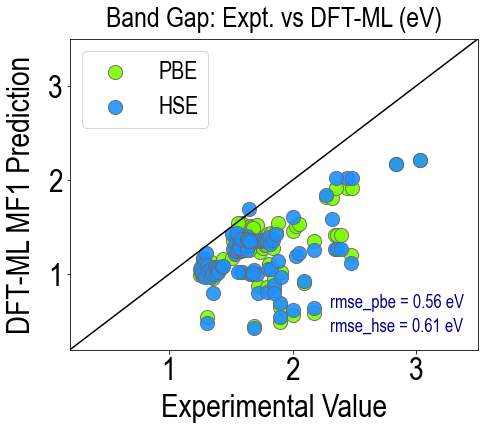

In [65]:
###   Expt vs PBE-ML and HSE-ML   ###

#Data_pbe = pd.read_excel('Expt_pred.xlsx', 'PBE_sf')
#Data_hse = pd.read_excel('Expt_pred.xlsx', 'HSE_sf')
Data_pbe = pd.read_excel('Expt_pred.xlsx', 'PBE_mf1')
Data_hse = pd.read_excel('Expt_pred.xlsx', 'HSE_mf1')

gap_rmse_pbe = np.sqrt( sklearn.metrics.mean_squared_error(Data_pbe.Expt_gap[:], Data_pbe.Pred_gap_mean[:]) )
gap_rmse_hse = np.sqrt( sklearn.metrics.mean_squared_error(Data_hse.Expt_gap[:], Data_hse.Pred_gap_mean[:]) )

#gap_rmse_pbe = np.sqrt( sklearn.metrics.mean_squared_error(Data_pbe.Expt_gap[:], Data_pbe.Pred_gap_low_en[:]) )
#gap_rmse_hse = np.sqrt( sklearn.metrics.mean_squared_error(Data_hse.Expt_gap[:], Data_hse.Pred_gap_low_en[:]) )


n = len(Data.Index[:])

fig = plt.figure( figsize=(7,6) )
plt.subplots_adjust(left=0.16, bottom=0.18, right=0.97, top=0.90)
plt.rc('font', family='Arial narrow')

a = [-175,0,125]
b = [-175,0,125]

plt.plot(b, a, c='k', ls='-')
te = '%.2f' % gap_rmse_pbe
plt.text(2.3, 0.65, 'rmse_pbe = ' + te + ' eV', c='navy', fontsize=18)
te = '%.2f' % gap_rmse_hse
plt.text(2.3, 0.40, 'rmse_hse = ' + te + ' eV', c='navy', fontsize=18)
plt.xlim([0.2, 3.5])
plt.ylim([0.2, 3.5])
plt.xticks([1.0, 2.0, 3.0], fontsize=32)
plt.yticks([1.0, 2.0, 3.0], fontsize=32)
plt.xlabel('Experimental Value', fontsize=32, labelpad=8)
plt.scatter(Data_pbe.Expt_gap[:], Data_pbe.Pred_gap_mean[:], c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='PBE')
plt.scatter(Data_hse.Expt_gap[:], Data_hse.Pred_gap_mean[:], c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='HSE')
plt.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':24})
plt.title('Band Gap: Expt. vs DFT-ML (eV)', c='k', fontsize=28, pad=12)


#plt.ylabel('DFT-ML SF Prediction', fontsize=32, labelpad=12)
#plt.savefig('plot_expt_vs_dft-ml-sf.pdf', dpi=450)

plt.ylabel('DFT-ML MF1 Prediction', fontsize=32, labelpad=12)
plt.savefig('plot_expt_vs_dft-ml-mf1.pdf', dpi=450)




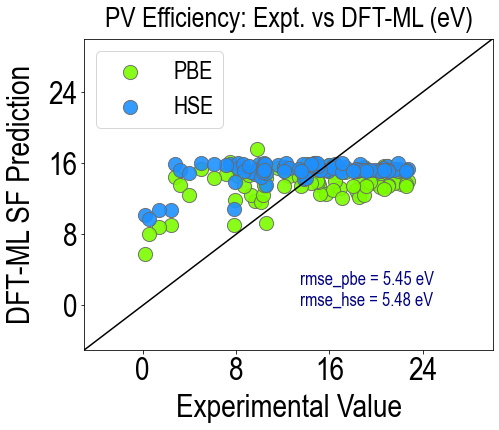

In [69]:
###   Expt vs PBE-ML and HSE-ML   ###

Data_pbe = pd.read_excel('Expt_pred.xlsx', 'PBE_sf')
Data_hse = pd.read_excel('Expt_pred.xlsx', 'HSE_sf')
#Data_pbe = pd.read_excel('Expt_pred.xlsx', 'PBE_mf1')
#Data_hse = pd.read_excel('Expt_pred.xlsx', 'HSE_mf1')

gap_rmse_pbe = np.sqrt( sklearn.metrics.mean_squared_error(Data_pbe.Expt_pce[0:87]*100, Data_pbe.Pred_slme_mean[0:87]*100) )
gap_rmse_hse = np.sqrt( sklearn.metrics.mean_squared_error(Data_hse.Expt_pce[0:87]*100, Data_hse.Pred_slme_mean[0:87]*100) )

#gap_rmse_pbe = np.sqrt( sklearn.metrics.mean_squared_error(Data_pbe.Expt_pce[0:87], Data_pbe.Pred_slme_low_en[0:87]) )
#gap_rmse_hse = np.sqrt( sklearn.metrics.mean_squared_error(Data_hse.Expt_pce[0:87], Data_hse.Pred_slme_low_en[0:87]) )


n = len(Data.Index[:])

fig = plt.figure( figsize=(7,6) )
plt.subplots_adjust(left=0.16, bottom=0.18, right=0.97, top=0.90)
plt.rc('font', family='Arial narrow')

a = [-175,0,125]
b = [-175,0,125]

plt.plot(b, a, c='k', ls='-')
te = '%.2f' % gap_rmse_pbe
plt.text(13.5, 2.4, 'rmse_pbe = ' + te + ' eV', c='navy', fontsize=18)
te = '%.2f' % gap_rmse_hse
plt.text(13.5, 0.0, 'rmse_hse = ' + te + ' eV', c='navy', fontsize=18)
plt.xlim([-5, 30])
plt.ylim([-5, 30])
plt.xticks([0, 8, 16, 24], fontsize=32)
plt.yticks([0, 8, 16, 24], fontsize=32)
plt.xlabel('Experimental Value', fontsize=32, labelpad=8)
plt.scatter(Data_pbe.Expt_pce[0:87]*100, Data_pbe.Pred_slme_mean[0:87]*100, c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='PBE')
plt.scatter(Data_hse.Expt_pce[0:87]*100, Data_hse.Pred_slme_mean[0:87]*100, c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='HSE')
plt.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'Arial narrow','size':24})
plt.title('PV Efficiency: Expt. vs DFT-ML (eV)', c='k', fontsize=28, pad=12)


plt.ylabel('DFT-ML SF Prediction', fontsize=32, labelpad=12)
plt.savefig('plot_expt_vs_dft-ml-sf-SLME.pdf', dpi=450)

#plt.ylabel('DFT-ML MF1 Prediction', fontsize=32, labelpad=12)
#plt.savefig('plot_expt_vs_dft-ml-mf1-SLME.pdf', dpi=450)




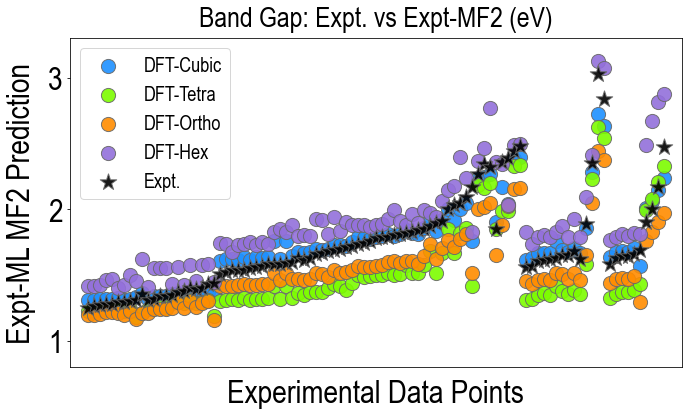

In [64]:
###   Expt vs PBE-ML and HSE-ML   ###

Data = pd.read_excel('Expt_pred.xlsx', 'PBE_sf')
Data_pbe = pd.read_excel('Expt_pred.xlsx', 'PBE_mf2')
Data_hse = pd.read_excel('Expt_pred.xlsx', 'HSE_mf2')
Data_expt = pd.read_excel('Expt_pred.xlsx', 'Expt_mf2')

n = len(Data.Index[:])
Data_actual_expt = Data.Expt_gap[:]

x = [0]*n
for i in range(0,n):
    x[i] = i+1

fig = plt.figure( figsize=(10,6) )
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=0.88)
plt.rc('font', family='Arial narrow')

plt.xlim([-2, 100])
plt.ylim([0.8, 3.3])
plt.xticks([], fontsize=32)
plt.yticks([1.0, 2.0, 3.0], fontsize=32)
plt.xlabel('Experimental Data Points', fontsize=32, labelpad=12)

# plt.scatter(x[:], Data_pbe.Pred_gap_mean[0:n], c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='DFT-Cubic')
# plt.scatter(x[:], Data_pbe.Pred_gap_mean[n:2*n], c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='DFT-Tetra')
# plt.scatter(x[:], Data_pbe.Pred_gap_mean[2*n:3*n], c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='DFT-Ortho')
# plt.scatter(x[:], Data_pbe.Pred_gap_mean[3*n:4*n], c='mediumpurple', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='DFT-Hex')

# plt.scatter(x[:], Data_hse.Pred_gap_mean[0:n], c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='DFT-Cubic')
# plt.scatter(x[:], Data_hse.Pred_gap_mean[n:2*n], c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='DFT-Tetra')
# plt.scatter(x[:], Data_hse.Pred_gap_mean[2*n:3*n], c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='DFT-Ortho')
# plt.scatter(x[:], Data_hse.Pred_gap_mean[3*n:4*n], c='mediumpurple', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='DFT-Hex')

plt.scatter(x[:], Data_expt.Pred_gap_mean[0:n], c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='DFT-Cubic')
plt.scatter(x[:], Data_expt.Pred_gap_mean[n:2*n], c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='DFT-Tetra')
plt.scatter(x[:], Data_expt.Pred_gap_mean[2*n:3*n], c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='DFT-Ortho')
plt.scatter(x[:], Data_expt.Pred_gap_mean[3*n:4*n], c='mediumpurple', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='DFT-Hex')

plt.scatter(x[:], Data_actual_expt[:], c='k', marker='*', s=300, edgecolors='dimgrey', alpha=0.9, label='Expt.')
plt.ylabel('DFT-ML MF2 Prediction', fontsize=32, labelpad=12)
plt.legend(loc='upper left', ncol=1, frameon=True, prop={'family':'Arial narrow','size':20})


# plt.title('Band Gap: Expt. vs PBE-MF2 (eV)', c='k', fontsize=32, pad=15)
# plt.savefig('plot_expt_vs_dft-ml-pbe-mf2.pdf', dpi=450)

# plt.title('Band Gap: Expt. vs HSE-MF2 (eV)', c='k', fontsize=28, pad=12)
# plt.savefig('plot_expt_vs_dft-ml-hse-mf2.pdf', dpi=450)

plt.ylabel('Expt-ML MF2 Prediction', fontsize=32, labelpad=12)
plt.title('Band Gap: Expt. vs Expt-MF2 (eV)', c='k', fontsize=28, pad=12)
plt.savefig('plot_expt_vs_dft-ml-expt-mf2.pdf', dpi=450)




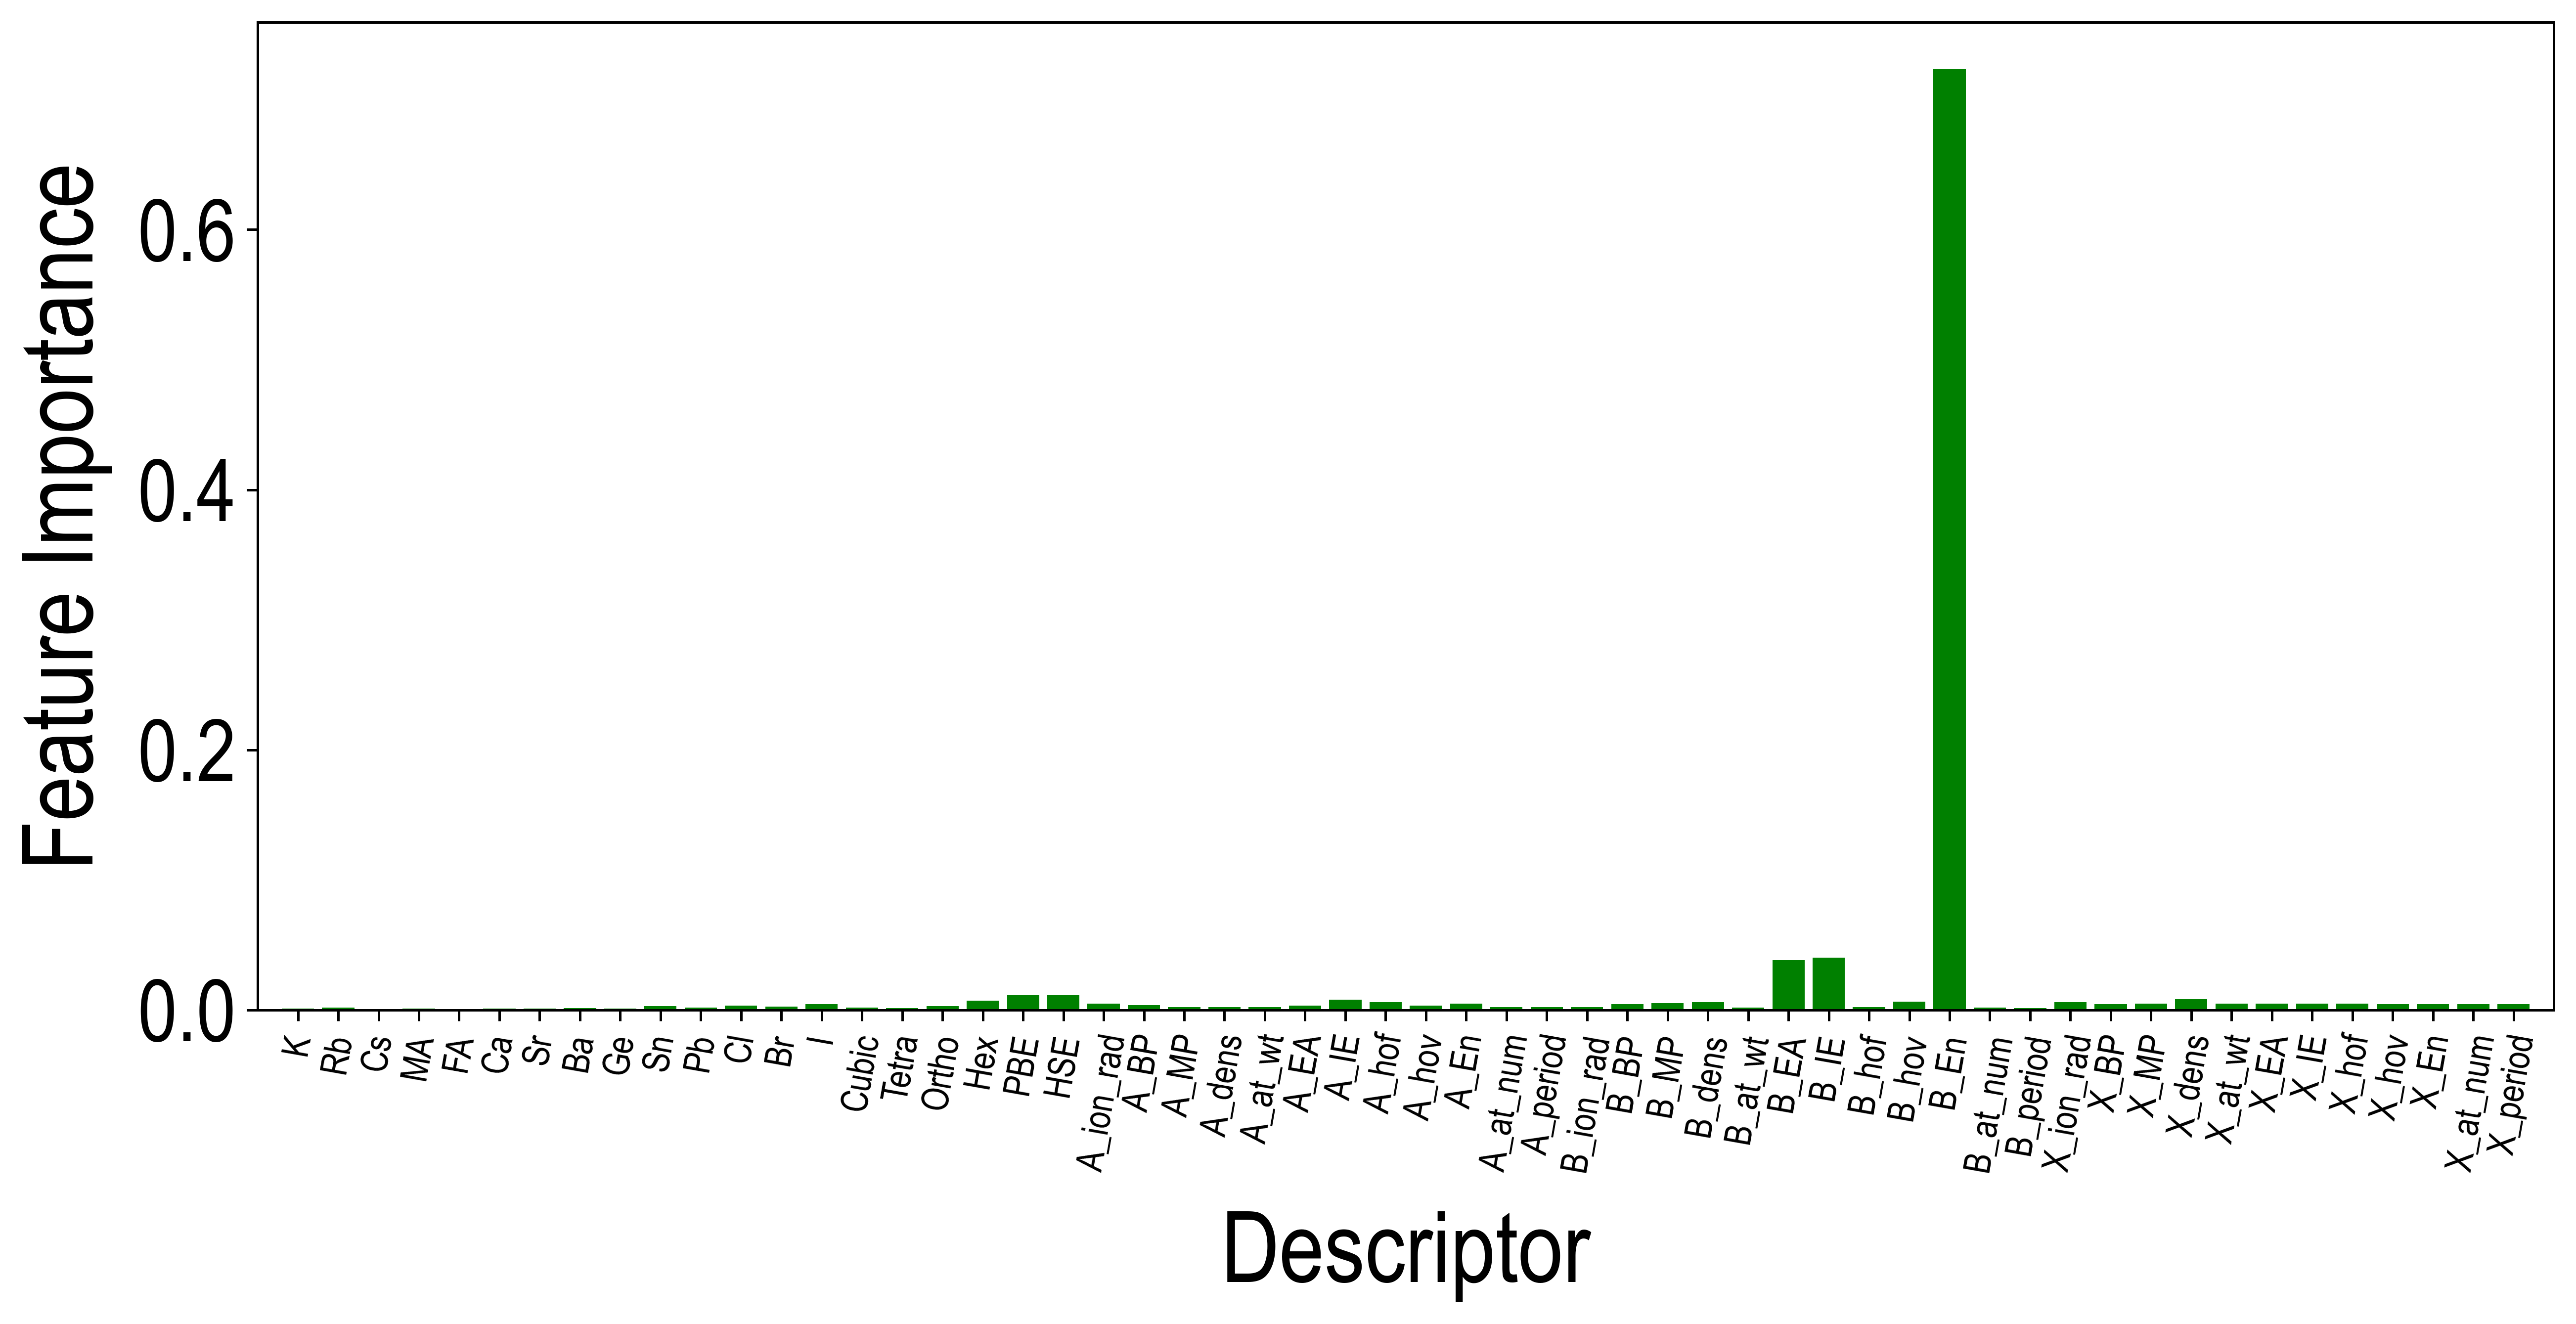

In [43]:
###   Plot RFR Feature Importance    ###

fig=plt.figure(figsize=(12,6),dpi=450)
plt.subplots_adjust(left=0.12, bottom=0.22, right=0.98, top=0.96)

Data = pd.read_excel('ML_data.xlsx', 'mf1')

plt.rc('font', family='Arial narrow')

n = 56
Labels = Data.Feature[0:n]
x = np.arange(n)

#plt.bar(x[:], Data.imp_decomp_mean[0:n], color='r', label='RFR, Decomp Energy')
#plt.bar(x[:], Data.imp_gap_mean[0:n], color='b', label='RFR, Band Gap')
plt.bar(x[:], Data.imp_slme_mean[0:n], color='g', label='RFR, SLME')
#plt.bar(x[:], Data.RFR[:], color='b', label='RFR')


plt.xlabel('Descriptor', fontname='Arial Narrow', size=32, labelpad=12)
plt.ylabel('Feature Importance', fontname='Arial Narrow', size=32, labelpad=8)

plt.rc('xtick', labelsize=28)
#plt.xticks([])
plt.rc('ytick', labelsize=28)
plt.xticks(x[:],Labels[:],rotation=80,fontsize=12)
#plt.ylim([0.0,100])
plt.xlim([-1,n])
#plt.legend(loc='center',ncol=3,bbox_to_anchor=(0.50, 0.90), frameon=True, prop={'family':'Arial narrow','size':28})
#plt.legend(bbox_to_anchor=(0.6, 0.65), frameon=False, prop={'family':'Arial narrow','size':16})
#plt.plot(b, a, c='k', ls='--')
#plt.plot(b, c, c='k', ls='--')
plt.savefig('plot_feat_imp.pdf', dpi=450)
#plt.show()


TypeError: set_ticks() got an unexpected keyword argument 'fontsize'

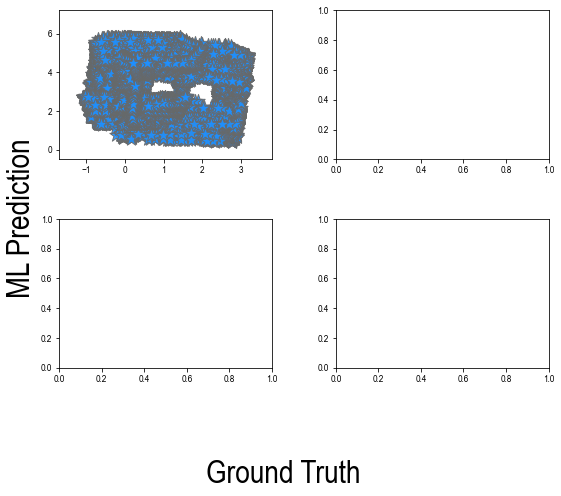

In [7]:
###   Visualize Outside Pred Data, Decomp vs Gap    ###

Data_1 = pd.read_excel('Outside_pred.xlsx', 'PBE_sf')
Data_2 = pd.read_excel('Outside_pred.xlsx', 'Expt_mf2')

n = len(Data_1.Index[:])
nn = int(n/4)

fig, ( [ax1, ax2], [ax3, ax4] ) = plt.subplots( nrows=2, ncols=2, figsize=(8,8) )
fig.text(0.5, 0.04, 'Ground Truth', ha='center', fontsize=32)
fig.text(0.02, 0.5, 'ML Prediction', va='center', rotation='vertical', fontsize=32)
plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
plt.rc('font', family='Arial narrow')

ax1.scatter(Data_1.ML_decomp_mean[0:nn], Data_2.ML_gap_mean[0:nn], c='dodgerblue', marker='*', s=200, edgecolors='dimgrey', alpha=0.9, label='Cubic')
ax1.set_xlim([-1.7, 3.8])
ax1.set_ylim([-0.5, 7.2])
ax1.set_xticks([-1.0, 0.0, 1.0, 2.0, 3.0], fontsize=32)
ax1.set_yticks([0.0, 1.5, 3.0, 4.5, 6.0], fontsize=32)
ax1.legend(loc='upper right',ncol=1, frameon=True, prop={'family':'Arial narrow','size':14})

ax2.scatter(Data_1.ML_decomp_mean[nn:2*nn], Data_2.ML_gap_mean[nn:2*nn], c='lawngreen', marker='*', s=200, edgecolors='dimgrey', alpha=0.9, label='Tetra')
ax2.set_xlim([-1.7, 3.8])
ax2.set_ylim([-0.5, 7.2])
ax2.set_xticks([-1.0, 0.0, 1.0, 2.0, 3.0], fontsize=32)
ax2.set_yticks([0.0, 1.5, 3.0, 4.5, 6.0], fontsize=32)
ax2.legend(loc='upper right',ncol=1, frameon=True, prop={'family':'Arial narrow','size':14})

ax3.scatter(Data_1.ML_decomp_mean[2*nn:3*nn], Data_2.ML_gap_mean[2*nn:3*nn], c='darkorange', marker='*', s=200, edgecolors='dimgrey', alpha=0.9, label='Ortho')
ax3.set_xlim([-1.7, 3.8])
ax3.set_ylim([-0.5, 7.2])
ax3.set_xticks([-1.0, 0.0, 1.0, 2.0, 3.0], fontsize=32)
ax3.set_yticks([0.0, 1.5, 3.0, 4.5, 6.0], fontsize=32)
ax3.legend(loc='upper right',ncol=1, frameon=True, prop={'family':'Arial narrow','size':14})

ax4.scatter(Data_1.ML_decomp_mean[3*nn:n], Data_2.ML_gap_mean[3*nn:n], c='mediumpurple', marker='*', s=200, edgecolors='dimgrey', alpha=0.9, label='Hex')
ax4.set_xlim([-1.7, 3.8])
ax4.set_ylim([-0.5, 7.2])
ax4.set_xticks([-1.0, 0.0, 1.0, 2.0, 3.0], fontsize=32)
ax4.set_yticks([0.0, 1.5, 3.0, 4.5, 6.0], fontsize=32)
ax4.legend(loc='upper right',ncol=1, frameon=True, prop={'family':'Arial narrow','size':14})


plt.savefig('plot_out_1.pdf', dpi=450)




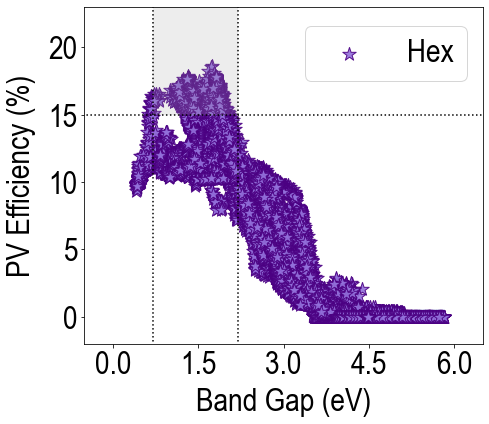

In [32]:
###   Visualize Outside Pred Data, Gap vs SLME    ###

Data = pd.read_excel('Outside_pred.xlsx', 'Expt_mf2')

n = len(Data.Index[:])
nn = int(n/4)

fig = plt.figure( figsize=(7,6) )
plt.subplots_adjust(left=0.18, bottom=0.18, right=0.97, top=0.96)
plt.rc('font', family='Arial narrow')

a = [0.7,0.7,0.7]
b = [-1000,0,1000]
c = [15,15,15]
d = [2.2,2.2,2.2]
plt.plot(a, b, c='k', ls=':')
plt.plot(d, b, c='k', ls=':')
plt.plot(b, c, c='k', ls=':')
x1 = np.arange(a[0], d[0],  0.01)

#plt.scatter(Data.ML_gap_mean[0:nn], Data.ML_slme_mean[0:nn]*100, c='dodgerblue', marker='*', s=300, edgecolors='navy', alpha=0.9, label='Cubic')
#plt.scatter(Data.ML_gap_mean[nn:2*nn], Data.ML_slme_mean[nn:2*nn]*100, c='lawngreen', marker='*', s=200, edgecolors='darkgreen', alpha=0.9, label='Tetra')
#plt.scatter(Data.ML_gap_mean[2*nn:3*nn], Data.ML_slme_mean[2*nn:3*nn]*100, c='darkorange', marker='*', s=200, edgecolors='red', alpha=0.9, label='Ortho')
plt.scatter(Data.ML_gap_mean[3*nn:n], Data.ML_slme_mean[3*nn:n]*100, c='mediumpurple', marker='*', s=200, edgecolors='indigo', alpha=0.9, label='Hex')

plt.fill_between(x1, c[0], 1000, facecolor='darkgrey', alpha=0.2)

plt.ylim([-2, 23])
plt.xlim([-0.5, 6.5])
plt.yticks([0, 5, 10, 15, 20], fontsize=32)
plt.xticks([0.0, 1.5, 3.0, 4.5, 6.0], fontsize=32)
plt.ylabel('PV Efficiency (%)', fontsize=32, labelpad=12)
plt.xlabel('Band Gap (eV)', fontsize=32, labelpad=8)
plt.legend(bbox_to_anchor=(1.00,0.99), ncol=1, frameon=True, prop={'family':'Arial narrow','size':32})

#plt.savefig('plot_out_2_cub.pdf', dpi=450)
#plt.savefig('plot_out_2_tet.pdf', dpi=450)
#plt.savefig('plot_out_2_ort.pdf', dpi=450)
plt.savefig('plot_out_2_hex.pdf', dpi=450)




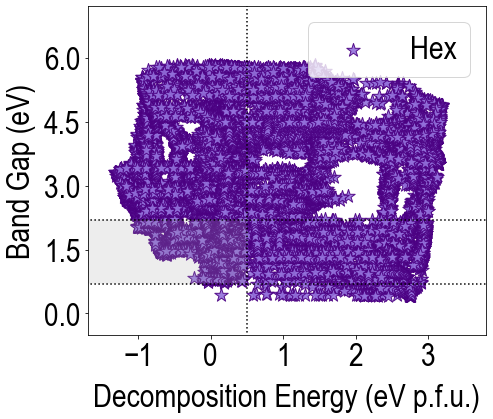

In [29]:
###   Visualize Outside Pred Data, Decomp vs Gap    ###

Data_1 = pd.read_excel('Outside_pred.xlsx', 'PBE_sf')
Data_2 = pd.read_excel('Outside_pred.xlsx', 'Expt_mf2')

n = len(Data_1.Index[:])
nn = int(n/4)

fig = plt.figure( figsize=(7,6) )
plt.subplots_adjust(left=0.18, bottom=0.20, right=0.97, top=0.96)
plt.rc('font', family='Arial narrow')

a = [0.7,0.7,0.7]
b = [-1000,0,1000]
c = [0.5,0.5,0.5]
d = [2.2,2.2,2.2]
plt.plot(b, a, c='k', ls=':')
plt.plot(b, d, c='k', ls=':')
plt.plot(c, b, c='k', ls=':')
x1 = np.arange(-1000, c[0],  0.01)

#plt.scatter(Data_1.ML_decomp_mean[0:nn], Data_2.ML_gap_mean[0:nn], c='dodgerblue', marker='*', s=300, edgecolors='navy', alpha=0.9, label='Cubic')
#plt.scatter(Data_1.ML_decomp_mean[nn:2*nn], Data_2.ML_gap_mean[nn:2*nn], c='lawngreen', marker='*', s=200, edgecolors='darkgreen', alpha=0.9, label='Tetra')
#plt.scatter(Data_1.ML_decomp_mean[2*nn:3*nn], Data_2.ML_gap_mean[2*nn:3*nn], c='darkorange', marker='*', s=200, edgecolors='red', alpha=0.9, label='Ortho')
plt.scatter(Data_1.ML_decomp_mean[3*nn:n], Data_2.ML_gap_mean[3*nn:n], c='mediumpurple', marker='*', s=200, edgecolors='indigo', alpha=0.9, label='Hex')

plt.fill_between(x1, a[0], d[0], facecolor='darkgrey', alpha=0.2)

plt.xlim([-1.7, 3.8])
plt.ylim([-0.5, 7.2])
plt.xticks([-1.0, 0.0, 1.0, 2.0, 3.0], fontsize=32)
plt.yticks([0.0, 1.5, 3.0, 4.5, 6.0], fontsize=32)
plt.xlabel('Decomposition Energy (eV p.f.u.)', fontsize=32, labelpad=12)
plt.ylabel('Band Gap (eV)', fontsize=32, labelpad=8)
plt.legend(loc='upper right', ncol=1, frameon=True, prop={'family':'Arial narrow','size':32})

#plt.savefig('plot_out_1_cub.pdf', dpi=450)
#plt.savefig('plot_out_1_tet.pdf', dpi=450)
#plt.savefig('plot_out_1_ort.pdf', dpi=450)
plt.savefig('plot_out_1_hex.pdf', dpi=450)




In [2]:
###  Read Data  ###


##  Choose Dataset Type  ##
#Data = 'PBE'
#Data = 'HSE'
Data = 'PBE_and_HSE'

##  Choose Descriptor Type  ##
#Desc = 'Composition Only'
#Desc = 'Elemental Only'
Desc = 'Composition and Elemental'


if Data == 'PBE':
#    !wget https://raw.githubusercontent.com/mannodiarun/perovs_dft_ml/main/PBE_data.csv
    D = read_csv('PBE_data.csv')
    df = pd.DataFrame(D)
    Index = df.Index
    Formula = df.Formula
    Decomp = df.Decomp
    Gap = df.Gap
    SLME = df.SLME
    Comp_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
    Elem_desc = pd.DataFrame(D, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    All_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    
    D_2 = read_csv('Expt_desc.csv')
    df_2 = pd.DataFrame(D_2)
    Comp_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
    Elem_desc_expt = pd.DataFrame(D_2, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    All_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    
    
if Data == 'HSE':
#    !wget https://raw.githubusercontent.com/mannodiarun/perovs_dft_ml/main/HSE_data.csv
    D = read_csv('HSE_data.csv')
    df = pd.DataFrame(D)
    Index = df.Index
    Formula = df.Formula
    Decomp = df.Decomp
    Gap = df.Gap
    SLME = df.SLME
    Comp_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
    Elem_desc = pd.DataFrame(D, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    All_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    
    D_2 = read_csv('Expt_desc.csv')
    df_2 = pd.DataFrame(D_2)
    Comp_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
    Elem_desc_expt = pd.DataFrame(D_2, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    All_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])


if Data == 'PBE_and_HSE':
#    !wget https://raw.githubusercontent.com/mannodiarun/perovs_dft_ml/main/PBE_and_HSE_data.csv
    D = read_csv('PBE_and_HSE_data.csv')
    df = pd.DataFrame(D)
    Index = df.Index
    Formula = df.Formula
    Decomp = df.Decomp
    Gap = df.Gap
    SLME = df.SLME
    Comp_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE'])
    Elem_desc = pd.DataFrame(D, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    All_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    
    D_2 = read_csv('Expt_desc_2.csv')
    df_2 = pd.DataFrame(D_2)
    Comp_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE'])
    Elem_desc_expt = pd.DataFrame(D_2, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    All_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
    

if Desc == 'Composition Only':
    X = copy.deepcopy(Comp_desc)
    X_expt = copy.deepcopy(Comp_desc_expt)
if Desc == 'Elemental Only':
    X = copy.deepcopy(Elem_desc)
    X_expt = copy.deepcopy(Elem_desc_expt)
if Desc == 'Composition and Elemental':
    X = copy.deepcopy(All_desc)
    X_expt = copy.deepcopy(All_desc_expt)
    
n = Index.size
m = int(X.size/n)
X_fl = np.array(X, dtype="float32")
n_exp = int(X_expt.size/m)
X_expt_fl = np.array(X_expt, dtype="float32")



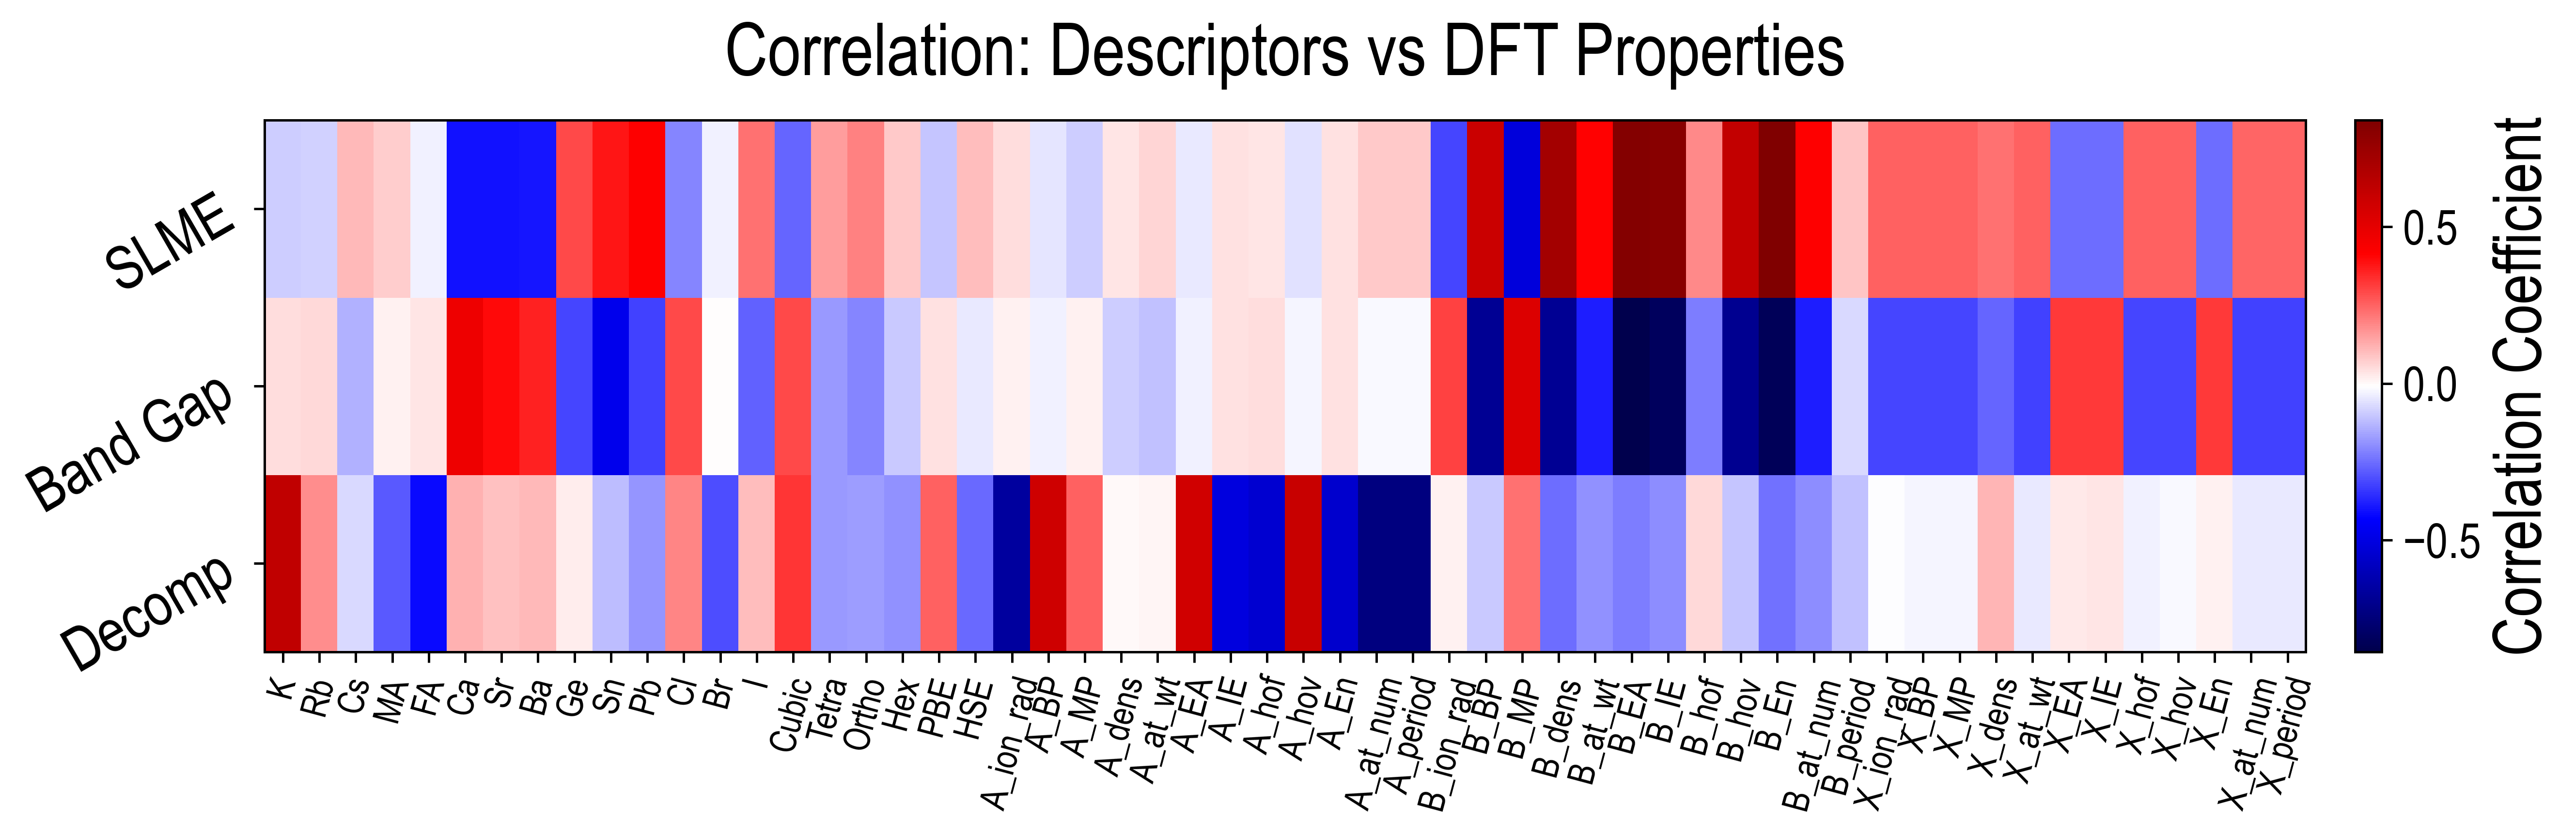

In [13]:
###   Pearson Coefficient of Linear Correlation    ###


Corr = [[0.0 for a in range(m)] for b in range(3)]

for i in range(0,m):
    x = stats.pearsonr(X_fl[:,i], Decomp[:])
    Corr[0][i] = x[0]
    x = stats.pearsonr(X_fl[:,i], Gap[:])
    Corr[1][i] = x[0]
    x = stats.pearsonr(X_fl[:,i], SLME[:])
    Corr[2][i] = x[0]

    
x = np.arange(m)
xx = [0.0]*m
for i in range(0,m):
    xx[i] = x[i]+0.5
y = [0.5,1.5,2.5]
f = 16
r = 75
Prop = ['Decomp', 'Band Gap', 'SLME']


scale = ['linear']
plotposition = [131, 132, 133]

fig=plt.figure(figsize=(12,4),dpi=450)
plt.rcParams.update({'font.size': 16})
plt.rc('font', family='Arial narrow')
plt.subplots_adjust(left=0.10, right=1.04, top=0.85, bottom=0.24, wspace=0.2, hspace=0.2)

ax = plt.plot(plotposition[0])
plt.plot(plotposition[0])
plt.xscale(scale[0])
plt.yscale(scale[0])
plt.xlim([0,m])
plt.ylim([0,3])

#Labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE']
#Labels = ['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period']
Labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period']


plt.xticks(xx[0:m], Labels[0:m], rotation=75, fontsize=12)

plt.yticks(y[:], Prop[:], rotation=30, fontsize=20)
plt.title('Correlation: Descriptors vs DFT Properties', fontname='Arial narrow', size=24, horizontalalignment='center', pad=15)
plt.pcolor(Corr, cmap='seismic')
cbar = plt.colorbar(orientation="vertical", pad=0.02)
cbar.set_label(label='Correlation Coefficient', size=22)
plt.savefig('corr.pdf', dpi=450)



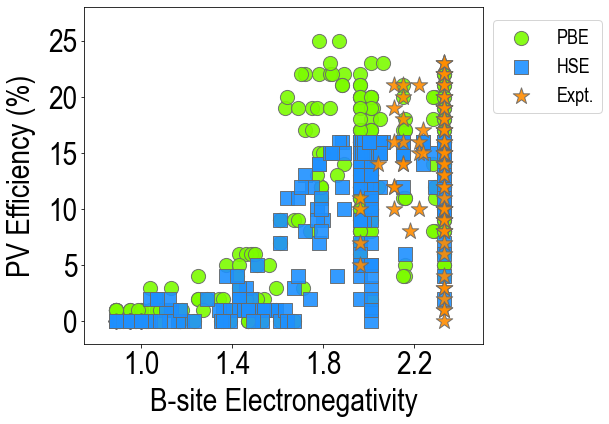

In [2]:
###   Gap or SLME vs B-site electronegativity   ###

#Data = pd.read_excel('DFT_pred.xlsx', 'PBE_sf')
#Data = pd.read_excel('DFT_pred.xlsx', 'HSE_sf')
#Data = pd.read_excel('DFT_pred.xlsx', 'PBE_HSE_mf1')
Data = pd.read_excel('DFT_pred.xlsx', 'PBE_HSE_expt_mf2')

n = len(Data.Index[:])

fig = plt.figure( figsize=(7,6) )
plt.subplots_adjust(left=0.18, bottom=0.18, right=0.97, top=0.96)
plt.rc('font', family='Arial narrow')

for i in range(0,n):

    if Data.PBE[i] == 1:
#        plt.scatter(Data.B_En[i], Data.Gap[i], c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        plt.scatter(Data.B_En[i], Data.SLME[i]*100, c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        
    if Data.HSE[i] == 1:
#        plt.scatter(Data.B_En[i], Data.Gap[i], c='dodgerblue', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        plt.scatter(Data.B_En[i], Data.SLME[i]*100, c='dodgerblue', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if Data.Expt[i] == 1:
#        plt.scatter(Data.B_En[i], Data.Gap[i], c='darkorange', marker='*', s=300, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        plt.scatter(Data.B_En[i], Data.SLME[i]*100, c='darkorange', marker='*', s=300, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

plt.scatter(1000, 1000, c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='PBE')
plt.scatter(1000, 1000, c='dodgerblue', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='HSE')
plt.scatter(1000, 1000, c='darkorange', marker='*', s=300, edgecolors='dimgrey', alpha=0.9, label='Expt.')

plt.ylim([-2, 28])
#plt.ylim([-0.5, 7.2])
plt.xlim([0.75,2.5])
plt.yticks([0, 5, 10, 15, 20, 25], fontsize=32)
#plt.yticks([0.0, 1.5, 3.0, 4.5, 6.0], fontsize=32)
plt.xticks([1.0, 1.4, 1.8, 2.2], fontsize=32)
plt.ylabel('PV Efficiency (%)', fontsize=32, labelpad=12)
#plt.ylabel('Band Gap (eV)', fontsize=32, labelpad=12)
plt.xlabel('B-site Electronegativity', fontsize=32, labelpad=8)
plt.legend(bbox_to_anchor=(1.00,0.99), ncol=1, frameon=True, prop={'family':'Arial narrow','size':20})

plt.savefig('plot_EN_slme.pdf', dpi=450)





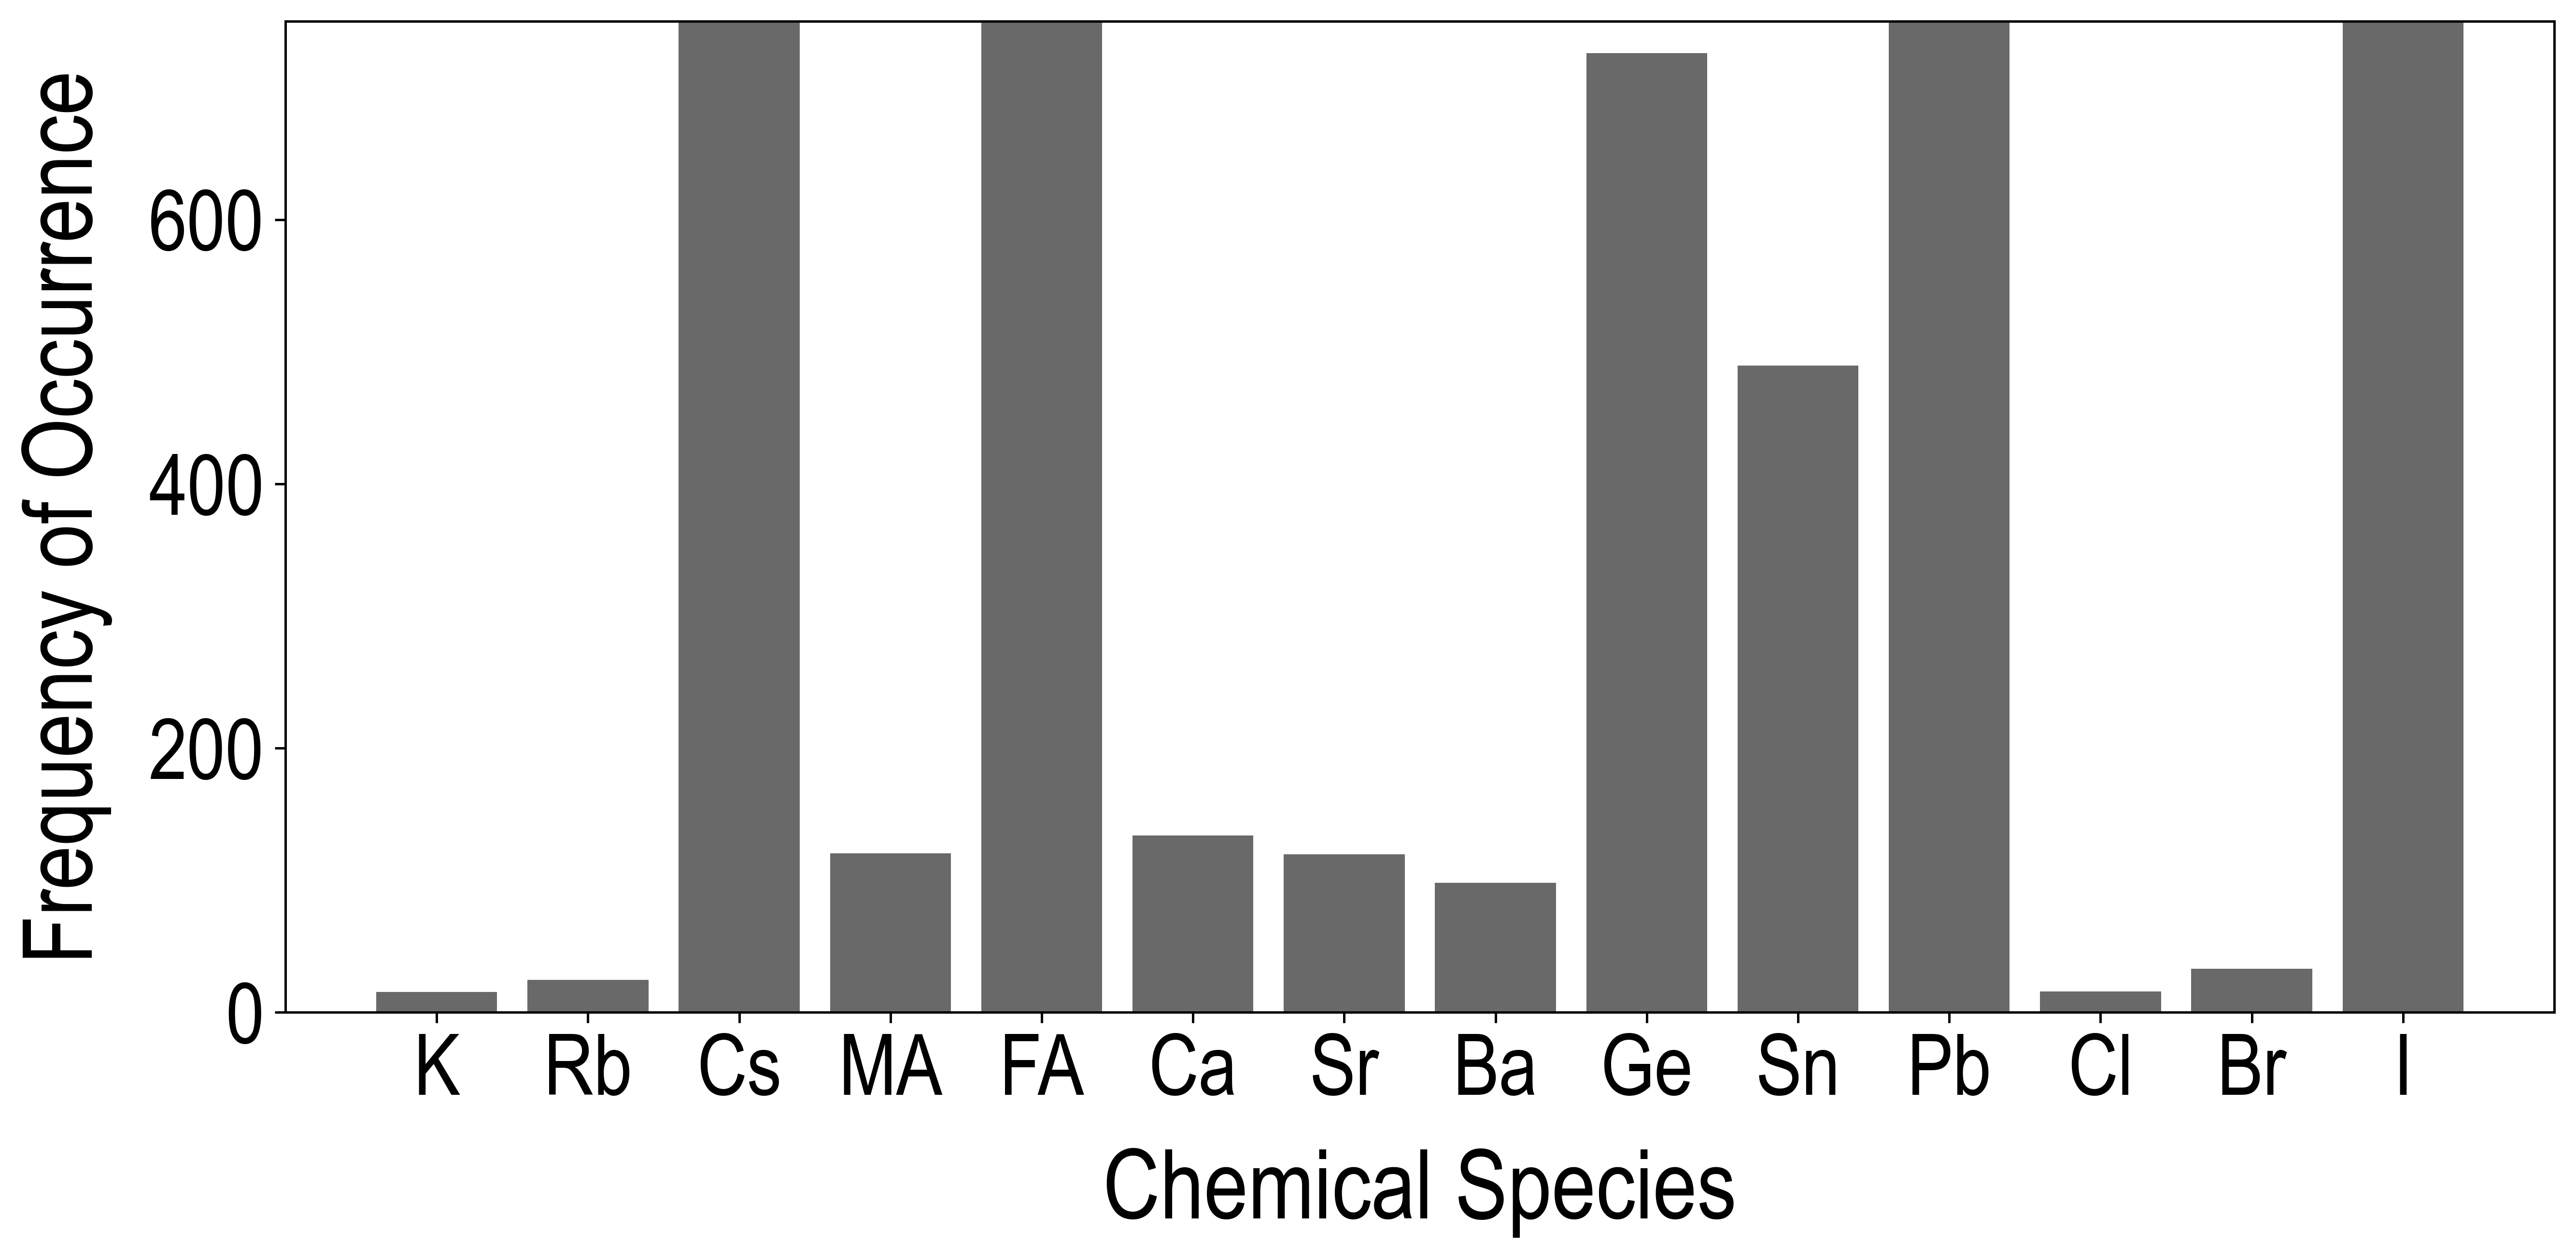

In [3]:
###   Plot Screened Compound Compositions    ###


Data = pd.read_excel('Out_pred_to_plot.xlsx', 'Sheet1')
s = len(Data.Index[:])
screened = 0

n = 14
Labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I']
x = np.arange(n)

Frac = [0.0]*n
for i in range(0,s):
#for i in range(0,int(s/4)):
#for i in range(int(s/4),int(s/2)):
#for i in range(int(s/2),int(3*s/4)):
#for i in range(int(3*s/4),s):
    if Data.ML_decomp_mean[i] < 0.2:
        if Data.ML_slme_mean[i] > 0.15:
            if Data.ML_gap_mean[i] > 1.0:
                if Data.ML_gap_mean[i] < 2.0:
                    Frac[0] = Frac[0] + Data.K[i]
                    Frac[1] = Frac[1] + Data.Rb[i]
                    Frac[2] = Frac[2] + Data.Cs[i]
                    Frac[3] = Frac[3] + Data.MA[i]
                    Frac[4] = Frac[4] + Data.FA[i]
                    Frac[5] = Frac[5] + Data.Ca[i]
                    Frac[6] = Frac[6] + Data.Sr[i]
                    Frac[7] = Frac[7] + Data.Ba[i]
                    Frac[8] = Frac[8] + Data.Ge[i]
                    Frac[9] = Frac[9] + Data.Sn[i]
                    Frac[10] = Frac[10] + Data.Pb[i]
                    Frac[11] = Frac[11] + Data.Cl[i]
                    Frac[12] = Frac[12] + Data.Br[i]
                    Frac[13] = Frac[13] + Data.I[i]
                    screened = screened + 1


fig=plt.figure(figsize=(12,6),dpi=450)
plt.subplots_adjust(left=0.13, bottom=0.20, right=0.98, top=0.96)

plt.rc('font', family='Arial narrow')
plt.bar(x[:], Frac[:], color='grey', width=0.6, label='_nolabel_')
#plt.bar(x[:], Frac[:], color='dodgerblue', label='Cubic')
#plt.bar(x[:], Frac[:], color='lawngreen', label='Tetra')
#plt.bar(x[:], Frac[:], color='darkorange', label='Ortho')
#plt.bar(x[:], Frac[:], color='mediumpurple', label='Hex')

plt.xlabel('Chemical Species', fontname='Arial Narrow', size=32, labelpad=12)
plt.ylabel('Frequency of Occurrence', fontname='Arial Narrow', size=32, labelpad=12)

plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.xticks(x[:], Labels[:], rotation=0, fontsize=28)
plt.yticks([0,500,1000,1500,2000,2500], fontsize=28)
plt.ylim([0,2700])
plt.xlim([-1,n])
#plt.legend(loc='upper left', ncol=1, frameon=True, prop={'family':'Arial narrow','size':28})
#plt.legend(bbox_to_anchor=(0.6, 0.65), frameon=False, prop={'family':'Arial narrow','size':16})
#plt.plot(b, a, c='k', ls='--')
#plt.plot(b, c, c='k', ls='--')
plt.savefig('plot_screen_freq_all.pdf', dpi=450)
#plt.savefig('plot.pdf', dpi=450)
#plt.show()


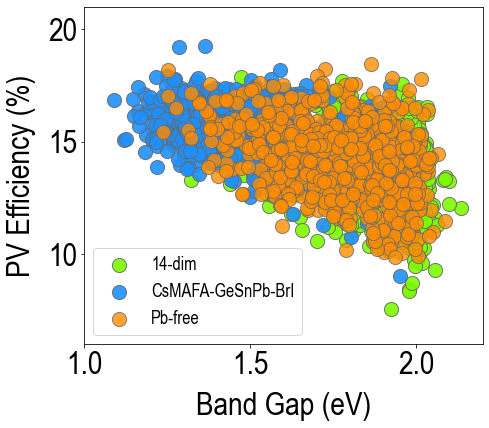

In [20]:
###   Gap or SLME vs B-site electronegativity   ###

Data_1 = pd.read_excel('GA_results.xlsx', '18-dim')
Data_2 = pd.read_excel('GA_results.xlsx', '14-dim-cub')
Data_3 = pd.read_excel('GA_results.xlsx', '14-dim-tet')
Data_4 = pd.read_excel('GA_results.xlsx', '14-dim-ort')
Data_5 = pd.read_excel('GA_results.xlsx', '14-dim-hex')
Data_6 = pd.read_excel('GA_results.xlsx', 'CsMAFA-GeSnPb-BrI-cub')
Data_7 = pd.read_excel('GA_results.xlsx', 'CsMAFA-GeSnPb-BrI-tet')
Data_8 = pd.read_excel('GA_results.xlsx', 'CsMAFA-GeSnPb-BrI-ort')
Data_9 = pd.read_excel('GA_results.xlsx', 'CsMAFA-GeSnPb-BrI-hex')
Data_10 = pd.read_excel('GA_results.xlsx', 'Pb-free-cub')
Data_11 = pd.read_excel('GA_results.xlsx', 'Pb-free-tet')
Data_12 = pd.read_excel('GA_results.xlsx', 'Pb-free-ort')
Data_13 = pd.read_excel('GA_results.xlsx', 'Pb-free-hex')

n = len(Data_1.GA_run[:])

fig = plt.figure( figsize=(7,6) )
plt.subplots_adjust(left=0.18, bottom=0.18, right=0.97, top=0.96)
plt.rc('font', family='Arial narrow')

plt.scatter(Data_1.Gap[:], Data_1.PCE[:]*100, c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
plt.scatter(Data_2.Gap[:], Data_2.PCE[:]*100, c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='14-dim')
plt.scatter(Data_3.Gap[:], Data_3.PCE[:]*100, c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
plt.scatter(Data_4.Gap[:], Data_4.PCE[:]*100, c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
plt.scatter(Data_5.Gap[:], Data_5.PCE[:]*100, c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

plt.scatter(Data_6.Gap[:], Data_6.PCE[:]*100, c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='CsMAFA-GeSnPb-BrI')
plt.scatter(Data_7.Gap[:], Data_7.PCE[:]*100, c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
plt.scatter(Data_8.Gap[:], Data_8.PCE[:]*100, c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
plt.scatter(Data_9.Gap[:], Data_9.PCE[:]*100, c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

plt.scatter(Data_10.Gap[:], Data_10.PCE[:]*100, c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.8, label='Pb-free')
plt.scatter(Data_11.Gap[:], Data_11.PCE[:]*100, c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.8, label='_nolabel_')
plt.scatter(Data_12.Gap[:], Data_12.PCE[:]*100, c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.8, label='_nolabel_')
plt.scatter(Data_13.Gap[:], Data_13.PCE[:]*100, c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.8, label='_nolabel_')

#plt.scatter(1000, 1000, c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='PBE')
#plt.scatter(1000, 1000, c='dodgerblue', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='HSE')
#plt.scatter(1000, 1000, c='darkorange', marker='*', s=300, edgecolors='dimgrey', alpha=0.9, label='Expt.')

plt.ylim([6, 21])
plt.xlim([1.0, 2.2])
plt.yticks([10, 15, 20], fontsize=32)
plt.xticks([1.0, 1.5, 2.0], fontsize=32)
plt.ylabel('PV Efficiency (%)', fontsize=32, labelpad=12)
plt.xlabel('Band Gap (eV)', fontsize=32, labelpad=12)
plt.legend(loc='lower left', ncol=1, frameon=True, prop={'family':'Arial narrow','size':18})

plt.savefig('plot_GA_gap_pv.pdf', dpi=450)



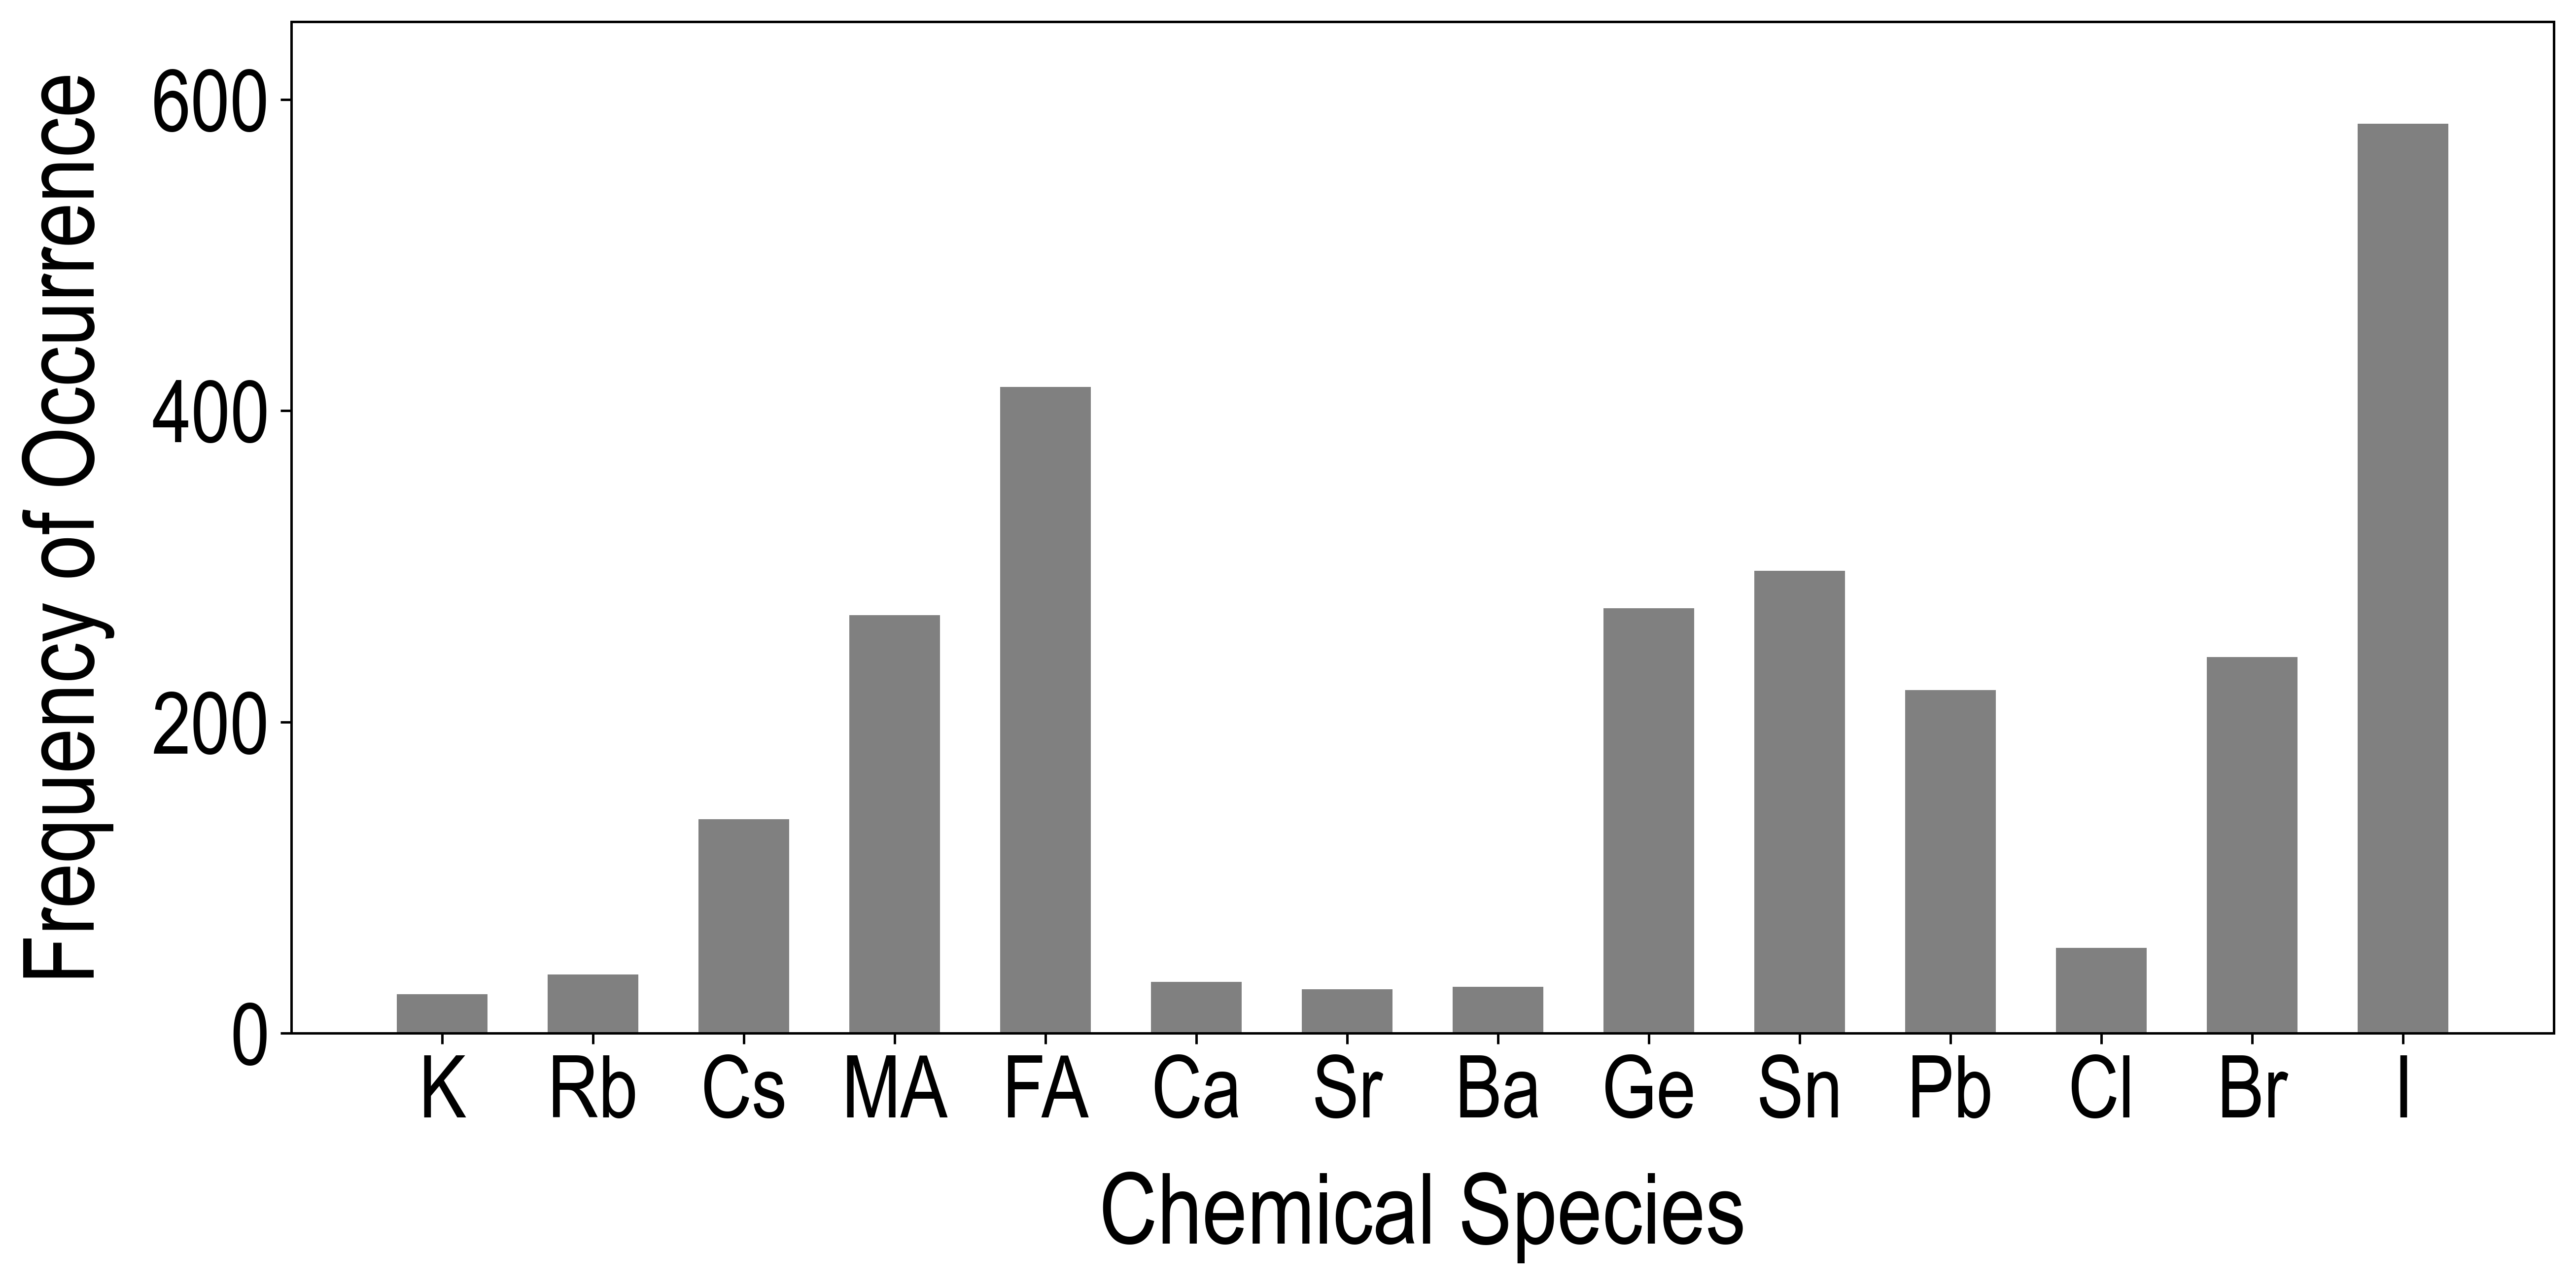

In [34]:
###   Plot GA-designed Compound Compositions    ###


Data_1 = pd.read_excel('GA_results.xlsx', '18-dim')
Data_2 = pd.read_excel('GA_results.xlsx', '14-dim-cub')
Data_3 = pd.read_excel('GA_results.xlsx', '14-dim-tet')
Data_4 = pd.read_excel('GA_results.xlsx', '14-dim-ort')
Data_5 = pd.read_excel('GA_results.xlsx', '14-dim-hex')
Data_6 = pd.read_excel('GA_results.xlsx', 'CsMAFA-GeSnPb-BrI-cub')
Data_7 = pd.read_excel('GA_results.xlsx', 'CsMAFA-GeSnPb-BrI-tet')
Data_8 = pd.read_excel('GA_results.xlsx', 'CsMAFA-GeSnPb-BrI-ort')
Data_9 = pd.read_excel('GA_results.xlsx', 'CsMAFA-GeSnPb-BrI-hex')
Data_10 = pd.read_excel('GA_results.xlsx', 'Pb-free-cub')
Data_11 = pd.read_excel('GA_results.xlsx', 'Pb-free-tet')
Data_12 = pd.read_excel('GA_results.xlsx', 'Pb-free-ort')
Data_13 = pd.read_excel('GA_results.xlsx', 'Pb-free-hex')

s = len(Data_1.GA_run[:])

screened = 0
sc_cub = 0
sc_tet = 0
sc_ort = 0
sc_hex = 0

n = 14
Labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I']
x = np.arange(n)

Data_keys = [Data_1, Data_2, Data_3, Data_4, Data_5, 
            Data_6, Data_7, Data_8, Data_9, Data_10, 
            Data_11, Data_12, Data_13]

Frac = [0.0]*n

for j in range(0,13):
    Data = Data_keys[j]
    for i in range(0,s):
        if Data.PCE[i] > 0.15:
            if Data.Sum_A[i] > 61 and Data.Sum_A[i] < 69:
                if Data.Sum_B[i] > 61 and Data.Sum_B[i] < 69:
                    if Data.Sum_X[i] > 61 and Data.Sum_X[i] < 69:
                        Frac[0] = Frac[0] + Data.K[i]/64
                        Frac[1] = Frac[1] + Data.Rb[i]/64
                        Frac[2] = Frac[2] + Data.Cs[i]/64
                        Frac[3] = Frac[3] + Data.MA[i]/64
                        Frac[4] = Frac[4] + Data.FA[i]/64
                        Frac[5] = Frac[5] + Data.Ca[i]/64
                        Frac[6] = Frac[6] + Data.Sr[i]/64
                        Frac[7] = Frac[7] + Data.Ba[i]/64
                        Frac[8] = Frac[8] + Data.Ge[i]/64
                        Frac[9] = Frac[9] + Data.Sn[i]/64
                        Frac[10] = Frac[10] + Data.Pb[i]/64
                        Frac[11] = Frac[11] + Data.Cl[i]/64
                        Frac[12] = Frac[12] + Data.Br[i]/64
                        Frac[13] = Frac[13] + Data.I[i]/64
                        screened = screened + 1
                        sc_cub = sc_cub + Data.Cub[i]
                        sc_tet = sc_tet + Data.Tet[i]
                        sc_ort = sc_ort + Data.Ort[i]
                        sc_hex = sc_hex + Data.Hex[i]


fig=plt.figure(figsize=(12,6),dpi=450)
plt.subplots_adjust(left=0.13, bottom=0.20, right=0.98, top=0.96)

plt.rc('font', family='Arial narrow')
plt.bar(x[:], Frac[:], color='grey', width=0.6, label='_nolabel_')
#plt.bar(x[:], Frac[:], color='dodgerblue', label='Cubic')
#plt.bar(x[:], Frac[:], color='lawngreen', label='Tetra')
#plt.bar(x[:], Frac[:], color='darkorange', label='Ortho')
#plt.bar(x[:], Frac[:], color='mediumpurple', label='Hex')

plt.xlabel('Chemical Species', fontname='Arial Narrow', size=32, labelpad=12)
plt.ylabel('Frequency of Occurrence', fontname='Arial Narrow', size=32, labelpad=12)

plt.rc('xtick', labelsize=28)
plt.rc('ytick', labelsize=28)
plt.xticks(x[:], Labels[:], rotation=0, fontsize=28)
plt.yticks([0,200,400,600], fontsize=28)
plt.ylim([0,650])
plt.xlim([-1,n])
#plt.legend(loc='upper left', ncol=1, frameon=True, prop={'family':'Arial narrow','size':28})
#plt.legend(bbox_to_anchor=(0.6, 0.65), frameon=False, prop={'family':'Arial narrow','size':16})
#plt.plot(b, a, c='k', ls='--')
#plt.plot(b, c, c='k', ls='--')
plt.savefig('plot_screen_freq_GA.pdf', dpi=450)
#plt.savefig('plot.pdf', dpi=450)
#plt.show()


In [31]:
sc_cub, sc_tet, sc_ort, sc_hex

(276.0, 215.5, 226.5, 161.0)